In [1]:
%load_ext autoreload
%autoreload 2

# Visualise ruggedness verified for trained models

In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.data.data_format_tools.common import write_json
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.utils.evolution import calculate_ruggedness_core
from evoscaper.utils.math import arrayise, make_flat_triangle
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.visualise import make_sort_hue
from evoscaper.utils.visualise import create_network_inset, make_nx_weights, vis_sampled_histplot

import matplotlib.gridspec
from scipy.cluster.hierarchy import fcluster

import os
import json
import sys
import numpy as np
import jax

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')


sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.2)
custom_palette = sns.blend_palette(['#ff9f9b', '#ffb482', '#fffea3', '#c1f6b8', '#a0e7e0', '#b9d3ee', '#d6a4ef', '#ff77a7'], n_colors=9)

# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 02_cvae_verify.ipynb --output=02_cvae_verify_2.ipynb --ExecutePreprocessor.timeout=-1

[CpuDevice(id=0)]

# Settings + load params

In [3]:
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_03_25__12_53_19')
config_rugg = load_json_as_dict(os.path.join(dir_src_rugg, 'config.json'))
fn_df_hpos_loaded = config_rugg['fn_df_hpos_loaded'].replace('notebooks/', '')
hpos = pd.Series(load_json_as_dict(fn_df_hpos_loaded))
dir_src_nn = os.path.dirname(fn_df_hpos_loaded)
fn_saves = os.path.join(dir_src_nn, [i for i in os.listdir(dir_src_nn) if i.startswith('saves')][0])
idxs_output = -1

config = {'fn_saves': fn_saves,
       'dir_src_rugg': dir_src_rugg}
top_write_dir = os.path.join('data', '16_visualise_rugged_verify', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)
with open(os.path.join(top_write_dir, 'config.json'), 'w') as f:
    json.dump(config, f)
print('top_write_dir:', top_write_dir)
    

top_write_dir: data/16_visualise_rugged_verify/2025_06_17__13_08_37


In [4]:
saves_loaded = load_json_as_dict(fn_saves)
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

config_bio = load_json_as_dict(config_dataset.filenames_verify_config)
if 'base_configs_ensemble' in config_bio:
    val_config = config_bio['base_configs_ensemble']['generate_species_templates']
    val_config.update(config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal'])
else:
    val_config = config_bio
    
    

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Load analytics - if necessary, stitch batches together from ruggedness directory

In [5]:
fn_analytics = os.path.join(dir_src_rugg, 'analytics.json')

if os.path.exists(fn_analytics):
    analytics_rugg = load_json_as_dict(fn_analytics)
    for k, v in analytics_rugg.items():
        analytics_rugg[k] = np.array(v)
    if 'adaptation' not in analytics_rugg.keys():
        analytics_rugg['adaptation'] = calculate_adaptation(analytics_rugg['sensitivity'], analytics_rugg['precision'], alpha=2)
else:
    # Stitch together ruggedness from batches
    analytics_rugg = {}
    # for fn_analytic in ['analytics.json', 'analytics2.json']:
    for dir_batch in [f'batch_{i}' for i in np.arange(12)]:
        if (not os.path.exists(os.path.join(dir_src_rugg, dir_batch))) or (
            len(os.listdir(os.path.join(dir_src_rugg, dir_batch))) == 0):
            continue
        analytics_batch = load_json_as_dict(os.path.join(dir_src_rugg, dir_batch, 'analytics.json'))
        # analytics_batch = load_json_as_dict(os.path.join(dir_src_rugg, fn_analytic))
        for k, v in analytics_batch.items():
            if k not in analytics_rugg:
                analytics_rugg[k] = np.array(v)
            else:
                analytics_rugg[k] = np.concatenate([analytics_rugg[k], np.array(v)], axis=0)
                
    if 'adaptation' not in analytics_rugg.keys():
        analytics_rugg['adaptation'] = calculate_adaptation(analytics_rugg['sensitivity'], analytics_rugg['precision'], alpha=2)

    write_json(analytics_rugg, fn_analytics)

In [6]:
analytics_rugg.pop('RMSE', None)
'1'

'1'

### Load fake circuits

In [7]:
# from evoscaper.utils.simulation import load_config_bio, sim, prep_cfg, setup_model_brn, compute_analytics
# from evoscaper.scripts.cvae_scan import generate_all_fake_circuits

# df_hpos = pd.DataFrame(hpos).T
# df_hpos['eval_n_to_sample'] = config_rugg['eval_n_to_sample']
# df_hpos['eval_cond_min'] = config_rugg['eval_cond_min']
# df_hpos['eval_cond_max'] = config_rugg['eval_cond_max']
# df_hpos['eval_n_categories'] = config_rugg['eval_n_categories']

# datasets = {v: pd.read_json(
#     v) for v in df_hpos['filenames_train_table'].unique() if os.path.exists(v)}
# input_species = datasets[list(datasets.keys())[
#     0]]['sample_name'].dropna().unique()
# fn_config_bio = df_hpos['filenames_verify_config'].dropna().unique()[0]

# config_bio = load_config_bio(
#     fn_config_bio, input_species, '../' + config_rugg.get('fn_simulation_settings'))

# model_brn, qreactions, postprocs, ordered_species = setup_model_brn(
#     config_bio, input_species)

# # df_hpos['output_species'] = df_hpos['output_species'].apply(lambda x: [x])
# all_fake_circuits, all_forward_rates, all_reverse_rates, all_sampled_cond = generate_all_fake_circuits(
#     df_hpos, datasets, input_species, postprocs)

all_fake_circuits = np.load(os.path.join(dir_src_rugg, 'all_fake_circuits.npy'))
all_sampled_cond = np.load(os.path.join(dir_src_rugg, '0', 'all_sampled_cond.npy'))

In [8]:
len(analytics_rugg['sensitivity']), all_fake_circuits.shape

(700000, (100000, 3, 3))

# Calculate ruggedness

In [9]:
n_samples = all_fake_circuits.shape[0]
n_interactions = make_flat_triangle(all_fake_circuits[0]).shape[-1]
n_perturbs = n_interactions + config_rugg['resimulate_analytics']
eps = config_rugg['eps_perc'] * np.abs(all_fake_circuits).max()
idx_output = -1

ruggedness = {}
# for analytic in config_dataset.objective_col:
for analytic in analytics_rugg.keys():
    ruggedness[analytic] = calculate_ruggedness_core(analytics_rugg, None, analytic,
                                                     config_rugg['resimulate_analytics'], n_samples, n_perturbs, eps)

In [10]:
if config_rugg['resimulate_analytics']:
    analytics_og = {k: np.array(v).reshape(n_samples, n_perturbs, -1)[:, -1, :] for k, v in analytics_rugg.items()}
else: 
    analytics_og = {}

In [11]:
k_rugg = 'Log ruggedness (adaptation)'

ruggedness[k_rugg] = np.log10(ruggedness['Log sensitivity'])

/tmp/ipykernel_9410/3644252730.py:3: RuntimeWarning: divide by zero encountered in log10
  ruggedness[k_rugg] = np.log10(ruggedness['Log sensitivity'])


/tmp/ipykernel_9410/1161289059.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x=sampled_rugg.flatten(), y=rugg_k[..., idx_output], palette='viridis')


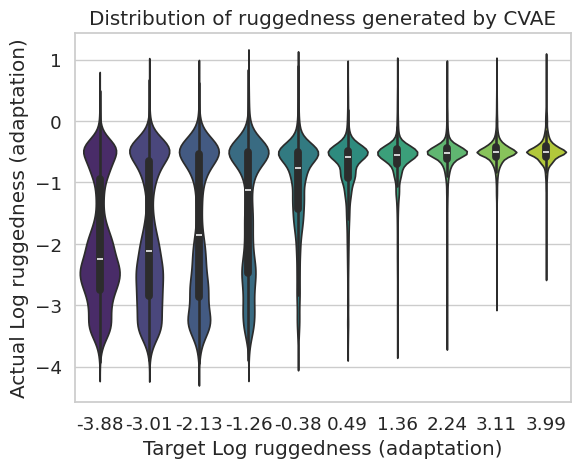

In [12]:
sampled_rugg = all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)]
rugg_k = ruggedness[k_rugg]
sampled_rugg = y_datanormaliser.create_chain_preprocessor_inverse(
    y_methods_preprocessing)(sampled_rugg, col=k_rugg)
ax = sns.violinplot(x=sampled_rugg.flatten(), y=rugg_k[..., idx_output], palette='viridis')
# ax = sns.barplot(x=sampled_rugg.flatten().round(1), y=rugg_sens[..., idx_output],
#                  hue=all_sampled_cond[..., config_dataset.objective_col.index(col_hue)].flatten())  # , alpha=0.5)
# hue=analytics_og['Log sensitivity'][..., idx_output], alpha=0.5)
# ax.get_legend().set_title('Target ' + col_hue)
plt.xlabel(f'Target {k_rugg}')
plt.xticks(ax.get_xticks(), [f'{i:.2f}' for i in sorted(np.unique(sampled_rugg.flatten()).round(2))])
plt.ylabel(f'Actual {k_rugg}')
plt.title('Distribution of ruggedness generated by CVAE')
plt.savefig(os.path.join(top_write_dir, 'ruggedness_violin.png'), dpi=300, bbox_inches='tight', transparent=True)



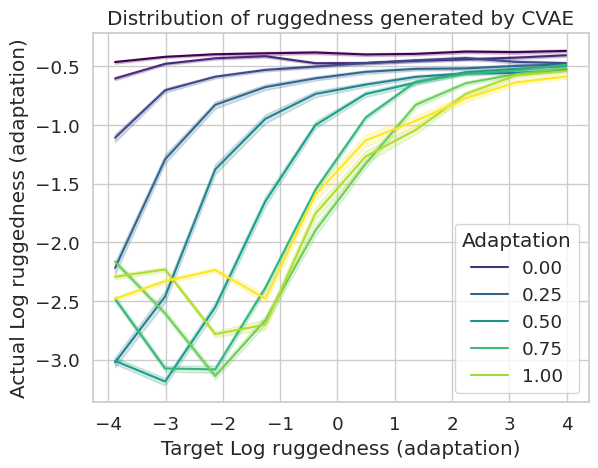

In [13]:
hue = all_sampled_cond[..., config_dataset.objective_col.index(
    'adaptation')].flatten()
df_plot = pd.DataFrame()
df_plot[f'Target {k_rugg}'] = sampled_rugg.flatten()
df_plot[f'Actual {k_rugg}'] = rugg_k[..., idx_output]
df_plot['Adaptation'] = all_sampled_cond[...,
                                         config_dataset.objective_col.index('adaptation')].flatten().round(2)
ax = sns.lineplot(df_plot, x=f'Target {k_rugg}', y=f'Actual {k_rugg}',
                  hue='Adaptation', palette='viridis')
# if ax.get_legend() is not None:
#     from bioreaction.misc.misc import flatten_listlike
#     leg_text = flatten_listlike(list(zip([f'{ii:.2f}' for ii in np.unique(
#         df_plot['Adaptation'])], [None] * df_plot['Adaptation'].nunique())))
#     plt.legend(ax.get_legend(), leg_text, title='Adaptation',
#                loc='upper left', bbox_to_anchor=(1, 1))
# plt.xticks(ax.get_xticks(), [f'{i:.2f}' for i in sorted(np.unique(sampled_rugg.flatten()).round(2))])
plt.title('Distribution of ruggedness generated by CVAE')
plt.savefig(os.path.join(top_write_dir, 'ruggedness_lineplot.png'),
            dpi=300, bbox_inches='tight', transparent=True)

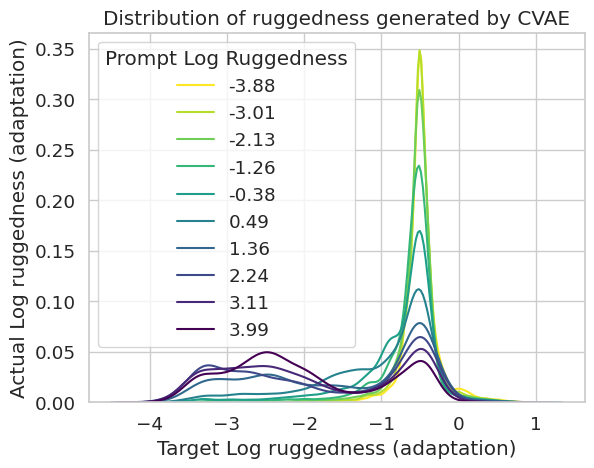

In [14]:
ax = sns.kdeplot(x=rugg_k[..., idx_output], hue=sampled_rugg.flatten(), palette='viridis')
# ax = sns.barplot(x=sampled_rugg.flatten().round(1), y=rugg_sens[..., idx_output],
#                  hue=all_sampled_cond[..., config_dataset.objective_col.index(col_hue)].flatten())  # , alpha=0.5)
# hue=analytics_og['Log sensitivity'][..., idx_output], alpha=0.5)
# ax.get_legend().set_title('Target ' + col_hue)
plt.xlabel(f'Target {k_rugg}')
plt.ylabel(f'Actual {k_rugg}')
plt.title('Distribution of ruggedness generated by CVAE')
leg_text = [f'{ii:.2f}' for ii in np.unique(sampled_rugg.flatten())]
plt.legend(leg_text, title='Prompt Log Ruggedness')
plt.savefig(os.path.join(top_write_dir, 'ruggedness_kde.png'), dpi=300, bbox_inches='tight', transparent=True)


In [15]:
n_species = 3
output_species = ['RNA_2', 'RNA_3']
all_species = [str(i) for i in range(rugg_k.shape[-1] - n_species)] + ['RNA_1'] + output_species

vis_sampled_histplot(rugg_k, all_species, output_species, all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)].reshape(-1, 1), # c,
                     title=f'Ruggedness of generated circuits', x_label=f'$Log_{{10}}$ Ruggedness', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'kde_rugg.png'),
                     f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, vline_uniqs=np.unique(sampled_rugg.flatten()),
                     hue_label='Prompt', figsize=(13, 5))

In [16]:
sampled_adapt = all_sampled_cond[..., config_dataset.objective_col.index('adaptation')]
idxs_adapt = np.where(sampled_adapt.flatten() >= 0.7 * sampled_adapt.max())
vis_sampled_histplot(rugg_k[idxs_adapt], all_species, output_species, 
                     all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)].reshape(-1, 1)[idxs_adapt],
                     title=f'Ruggedness of generated circuits', x_label=f'$Log_{{10}}$ Ruggedness', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'kde_rugg_hiadapt.png'),
                     f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, vline_uniqs=np.unique(sampled_rugg.flatten()),
                     hue_label='Prompt', figsize=(13, 5))
                     

In [27]:
y_datanormaliser.metadata

{'adaptation': {'median': Array([847.41235], dtype=float32),
  'iqr': Array([10.0177], dtype=float32),
  'min_val': Array([-10.490696], dtype=float32),
  'scale': Array([14.439846], dtype=float32),
  'feature_range': (0, 1)},
 'Log ruggedness (adaptation)': {'median': Array([0.2678774], dtype=float32),
  'iqr': Array([1.1374694], dtype=float32),
  'min_val': Array([-2.6595674], dtype=float32),
  'scale': Array([4.941231], dtype=float32),
  'feature_range': (0, 1)}}

In [38]:
np.unique(all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)].flatten())

array([-0.2       , -0.04444444,  0.11111111,  0.26666667,  0.42222222,
        0.57777778,  0.73333333,  0.88888889,  1.04444444,  1.2       ])

Now a KDE plot of ruggedness that's on a [0, 1] scale

In [ ]:
def norm_rugg(rugg, rugg_training, y_datanormaliser):
    # Robust scaling
    median = y_datanormaliser.metadata['Log ruggedness (adaptation)']['median']
    iqr = y_datanormaliser.metadata['Log ruggedness (adaptation)']['iqr']

    robust_scaled = (rugg - median) / iqr

    max_val = np.nanmax(rugg_training)
    min_val = np.nanmin(rugg_training)

    # Prevent division by zero
    scale = max_val - min_val
    scale = np.where(scale == 0, 1.0, scale)

    # Map to desired feature range
    min_range, max_range = (0, 1)
    # rugg_norm = ((robust_scaled - min_val) / scale) * \
    rugg_norm = ((robust_scaled - y_datanormaliser.metadata['Log ruggedness (adaptation)']['min_val']) / y_datanormaliser.metadata['Log ruggedness (adaptation)']['scale']) * \
        (max_range - min_range) + min_range

    return rugg_norm

norm_rugg_k = norm_rugg(rugg_k[idxs_adapt], df['Log ruggedness (adaptation)'].values, y_datanormaliser)

vis_sampled_histplot(norm_rugg_k, all_species, output_species, 
                     all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)].reshape(-1, 1)[idxs_adapt],
                     title=f'Ruggedness of generated circuits', x_label=f'$Log_{{10}}$ Ruggedness', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'kde_rugg_hiadapt2.png'),
                     f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, vline_uniqs=np.unique(all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)].flatten()),
                     hue_label='Prompt', figsize=(13, 5))


(np.float32(-inf),
 np.float32(0.70988446),
 np.float32(-inf),
 np.float32(1.2326058),
 np.float64(-2.7572991848),
 np.float64(2.8631999493))

/tmp/ipykernel_9410/1626143596.py:53: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1, i].set_ylim(0, count_max)


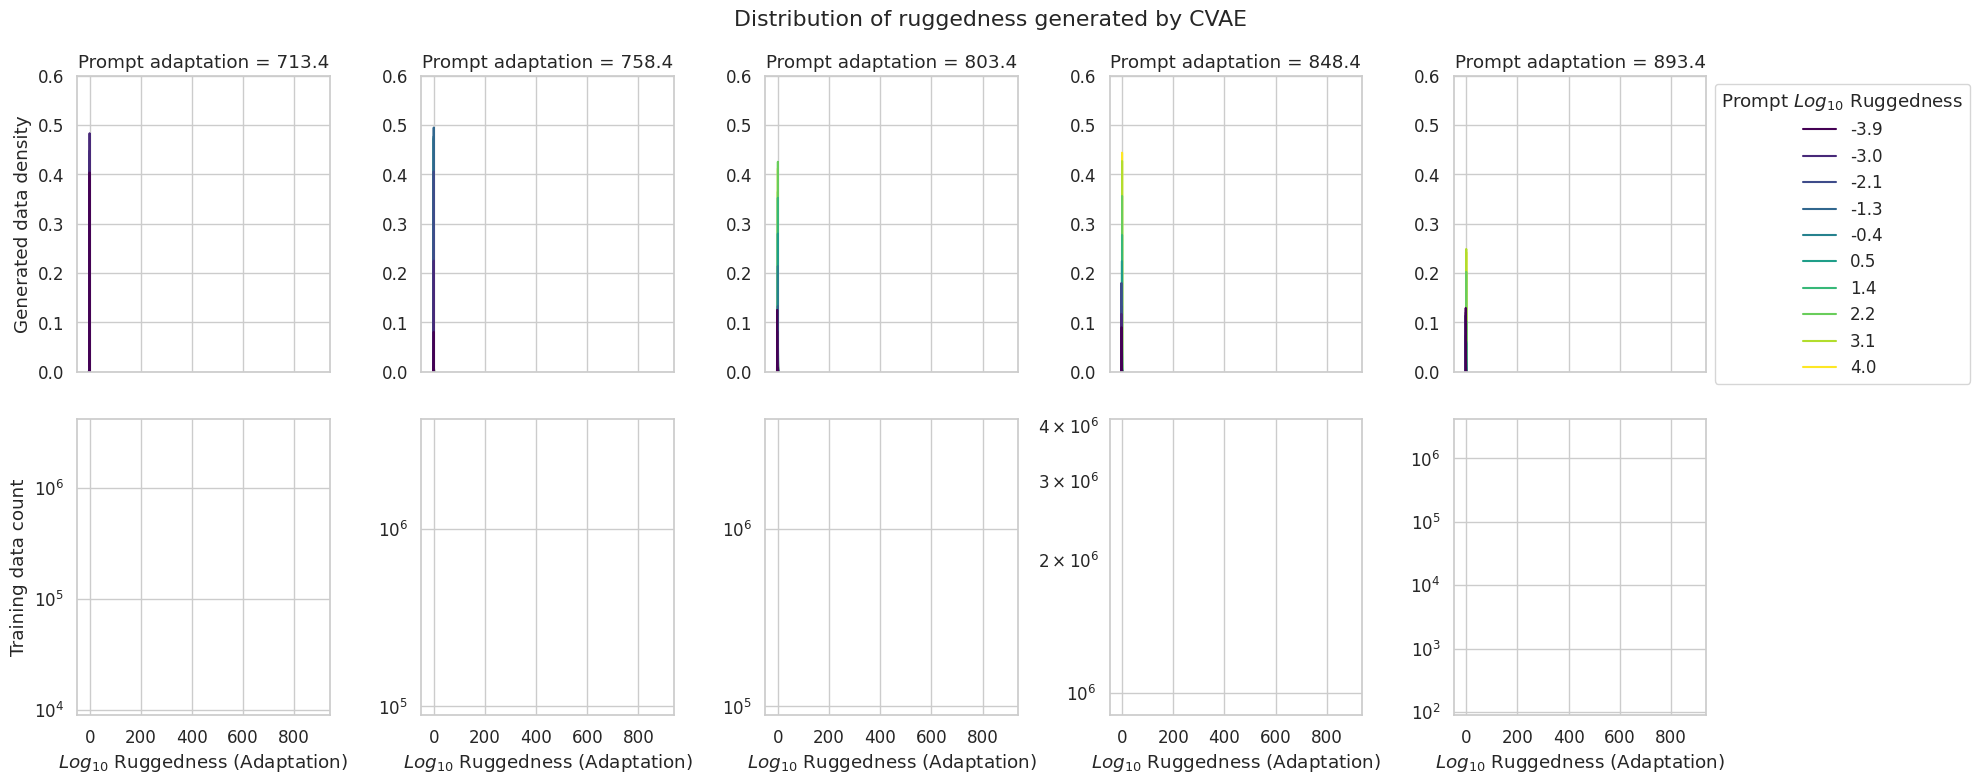

In [17]:
sns.set_context('notebook', font_scale=1.1)

if len(config_dataset.objective_col) == 2:
    k_other = 'adaptation'
    k_other_idx = config_dataset.objective_col.index(k_other)
    sampled_rev = y_datanormaliser.create_chain_preprocessor_inverse(
        y_methods_preprocessing)(all_sampled_cond[..., k_other_idx], col=k_other)
    uniq_sampled_other = np.unique(sampled_rev)
    uniq_sampled_other_half = uniq_sampled_other[::2]
    nrows = 2
    # ncols = int(np.ceil(len(uniq_sampled_other_half) / nrows))
    ncols = len(uniq_sampled_other_half)
    leg_text = [f'{ii:.2f}' for ii in np.unique(sampled_rugg.flatten())]
    fig, axs = plt.subplots(nrows, ncols, figsize=(
        4*ncols, 4*nrows), sharex=True) #, sharey=True)
    for i, v0 in enumerate(uniq_sampled_other_half):
        idxs_sampled0 = np.where(sampled_rev.flatten() == v0)[0]
        g = sns.kdeplot(x=rugg_k[idxs_sampled0, idx_output],
                    hue=sampled_rugg.flatten()[idxs_sampled0].round(1), palette='viridis', ax=axs.flat[i])
        axs.flat[i].set_xlabel(f'{k_rugg}')
        axs.flat[i].set_title(
            f'Prompt {k_other} = {v0:.1f}')
        if i == (len(uniq_sampled_other_half) - 1):
            legend = g.legend_
            if legend:
                for text in legend.get_texts():
                    text.set_text(f"{float(text.get_text()):.1f}")
            sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title=r'Prompt $Log_{10}$ Ruggedness')
        else:
            axs.flat[i].get_legend().remove()
        axs[0, i].set_ylim(0, 0.6)
        axs[0, i].set_ylabel('')
    axs[0, 0].set_ylabel('Generated data density')
    plt.suptitle('Distribution of ruggedness generated by CVAE')
    
    filt_samp = data['sample_name'] == 'RNA_2'
    binned_data_samples_other = np.array(list(map(lambda x: uniq_sampled_other_half[x], np.argmin(np.abs(data[filt_samp][k_other].values[None, :] - uniq_sampled_other_half[:, None]), axis=0))))
    binned_data_samples_rugg = np.array(list(map(lambda x: np.unique(sampled_rugg.flatten())[x], np.argmin(np.abs(data[filt_samp][k_rugg].values[None, :] - np.unique(sampled_rugg.flatten())[:, None]), axis=0))))
    df_xbinned = pd.DataFrame()
    df_xbinned[k_other] = binned_data_samples_other
    df_xbinned[k_rugg] = data[filt_samp][k_rugg].values
    df_xbinned[x_cols] = data[filt_samp][x_cols].values
    d = pd.melt(df_xbinned, id_vars=[k_other, k_rugg], value_vars=x_cols, value_name='Input x', var_name='X type')
    count_max = 1
    for i, v0 in enumerate(uniq_sampled_other_half):
        # sns.histplot(d[d[k_other] == v0], x=k_rugg, bins=30, ax=axs[1, i], log_scale=[False, True], element='step', fill=False)
        sns.histplot(d[d[k_other] == v0], x='adaptation', bins=30, ax=axs[1, i], log_scale=[False, True], element='step', fill=False)
        count_max = np.max([count_max, d[d[k_other] == v0].shape[0]])
        axs[1, i].set_ylabel('')
        axs[1, i].set_xlabel(r'$Log_{10}$ Ruggedness (Adaptation)')
    axs[1, 0].set_ylabel('Training data count')
    for i in range(ncols):
        axs[1, i].set_ylim(0, count_max)
        
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, 'ruggedness_by_prompt.png'), dpi=300, bbox_inches='tight', transparent=True)
    

/tmp/ipykernel_9410/785692435.py:6: RuntimeWarning: divide by zero encountered in log10
  ruggedness['adaptation'][..., idx_output] == 0, np.nan, np.log10(ruggedness['adaptation'][..., idx_output]))


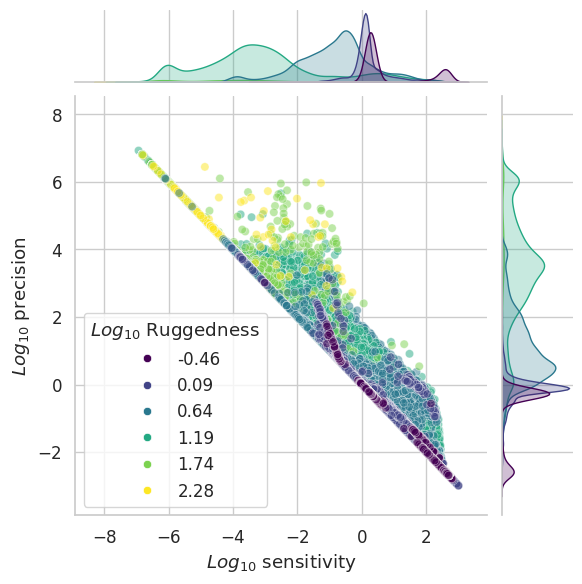

In [18]:
df_rugg = pd.DataFrame()
df_rugg['Log sensitivity'] = analytics_og['Log sensitivity'][..., idx_output]
df_rugg['Log precision'] = analytics_og['Log precision'][..., idx_output]
df_rugg['Adaptation'] = analytics_og['adaptation'][..., idx_output]
df_rugg['Log ruggedness (adaptation)'] = np.where(
    ruggedness['adaptation'][..., idx_output] == 0, np.nan, np.log10(ruggedness['adaptation'][..., idx_output]))
df_rugg['Log ruggedness (adaptation) bin'] = pd.cut(
    df_rugg['Log ruggedness (adaptation)'], bins=10)
df_rugg['Log ruggedness (adaptation) bin'] = df_rugg['Log ruggedness (adaptation) bin'].apply(
    lambda x: x.mid).astype(float).round(2)

idxs_show = make_sort_hue(df_rugg[df_rugg['Log ruggedness (adaptation) bin'] > -1]['Log ruggedness (adaptation) bin'].round(2), sort=True, sort_random=False, sort_flip_prop=4)

g = sns.jointplot(df_rugg[df_rugg['Log ruggedness (adaptation) bin'] > -1].iloc[idxs_show], 
              x='Log sensitivity', y='Log precision',
              hue='Log ruggedness (adaptation) bin', 
              alpha=0.5, palette='viridis')
plt.xlabel(r'$Log_{10}$ sensitivity')
plt.ylabel(r'$Log_{10}$ precision')
# plt.title('Adaptation')
# plt.legend(sorted(df_rugg[df_rugg['Log ruggedness (adaptation) bin'] > -1]['Log ruggedness (adaptation) bin'].unique().round(2)),
#     title='Log ruggedness (adaptation)')
l = plt.legend(title=r'$Log_{10}$ Ruggedness')
for line in l.get_lines():
    line.set(alpha=1.0)
plt.savefig(os.path.join(top_write_dir, 'sp_jointplot.png'), dpi=300, bbox_inches='tight', transparent=True)


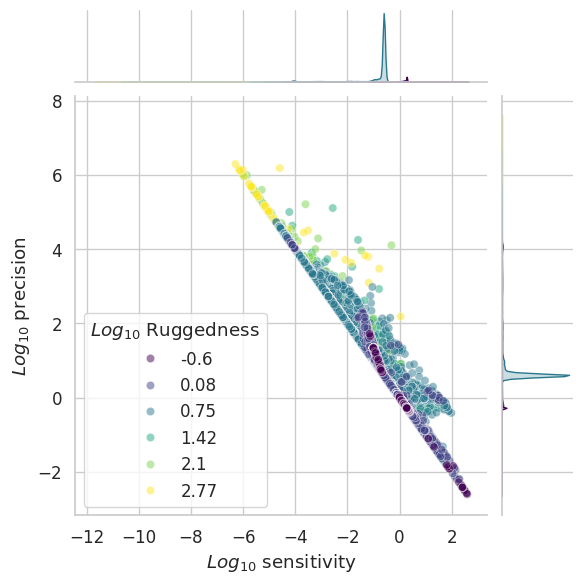

In [19]:
data['Log ruggedness (adaptation) bin'] = pd.cut(
    data['Log ruggedness (adaptation)'], bins=10)
data['Log ruggedness (adaptation) bin'] = data['Log ruggedness (adaptation) bin'].apply(
    lambda x: x.mid).astype(float).round(2)

idxs_show = make_sort_hue(data[data['Log ruggedness (adaptation) bin'] > -1]['Log ruggedness (adaptation) bin'].round(2), sort=True, sort_random=False, sort_flip_prop=4)

sns.jointplot(data[data['Log ruggedness (adaptation) bin'] > -1].iloc[idxs_show], 
              x='Log sensitivity', y='Log precision',
              hue='Log ruggedness (adaptation) bin', 
              alpha=0.5, palette='viridis')
plt.xlabel(r'$Log_{10}$ sensitivity')
plt.ylabel(r'$Log_{10}$ precision')
plt.legend(title=r'$Log_{10}$ Ruggedness')
plt.savefig(os.path.join(top_write_dir, 'sp_jointplot_training.png'), dpi=300, bbox_inches='tight', transparent=True)


# UMAP

In [20]:
from evoscaper.model.vae import sample_z
from evoscaper.utils.math import bin_array
import itertools
from evoscaper.utils.preprocess import format_with_subscript
import umap

n_show = 6000
n_categories = all_sampled_cond.shape[0]
random_state = 0
output_idx = -1
rng_key = jax.random.PRNGKey(random_state)  # Initialize a PRNG key with a seed
labels_chosen_a = config_dataset.objective_col  # ['Log sensitivity', k_rugg]
all_fake_circuits_flat = make_flat_triangle(all_fake_circuits)

analytics_show = {}
analytics_show['sensitivity'] = np.where(
    analytics_og['sensitivity'] == 0, np.nan, analytics_og['sensitivity'])
analytics_show['Log sensitivity'] = np.log10(analytics_og['sensitivity'])
analytics_show['adaptation'] = calculate_adaptation(
    analytics_og['sensitivity'], analytics_og['precision'], alpha=2)
analytics_show[k_rugg] = ruggedness[k_rugg]

cond_rev_all = np.concatenate([np.array(analytics_show[k])[
                              :, output_idx, None] for k in labels_chosen_a], axis=-1)
# cond_rev_all = cond_rev_all.reshape(n_categories, n_samples // n_categories, *cond_rev_all.shape[1:])
# x_rev_all = x_datanormaliser.create_chain_preprocessor_inverse(
#     x_methods_preprocessing)(all_fake_circuits_flat)
# x_rev_all = x_rev_all.reshape(-1, all_fake_circuits_flat.shape[-1])

# cond_binned = cond_rev_all
cond_binned = np.ones_like(cond_rev_all) * cond_rev_all
if not hpos.loc['prep_y_categorical']:
    for i in range(len(config_dataset.objective_col)):
        cond_binned[..., i] = bin_array(
            cond_rev_all[..., i], num_bins=5)[0].round(2)
cond_binned[~np.isfinite(cond_rev_all)] = np.nan
# x_bin = bin_array(all_fake_circuits_flat, num_bins=hpos.loc['prep_x_categorical_n_bins'])[
#     0].reshape(-1, all_fake_circuits_flat.shape[-1])


use_z = True
h_all = encoder(params, rng, np.concatenate(
    [all_fake_circuits_flat, all_sampled_cond.reshape(-1, all_sampled_cond.shape[-1])], axis=-1))
h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)
mu = h2mu(params, rng, h_all)
logvar = h2logvar(params, rng, h_all)
z_all = sample_z(mu, logvar, rng, deterministic=True)

embeddings = z_all if use_z else h_all

cond_unique = [np.unique(cond_binned[..., i])
               for i in range(cond_binned.shape[-1])]
cond_unique = np.array(list(itertools.product(*cond_unique)))

if n_show < len(cond_rev_all):
    idxs_show = []
    for c in cond_unique:
        idxs_show.extend(np.where((cond_binned != c).sum(
        # idxs_show.extend(np.where(((cond_binned != c) & np.isfinite(cond_binned)).sum(
            axis=-1) == 0)[0][:np.max([n_show//len(cond_unique), 5])])
    idxs_show = np.array(idxs_show).astype(int)
    if len(idxs_show) > n_show:
        idxs_show = jax.random.choice(rng_key, np.arange(
            len(cond_rev_all)), (n_show,), replace=False)
else:
    idxs_show = jax.random.choice(rng_key, np.arange(
        len(cond_rev_all)), (n_show,), replace=False).astype(int)

input_species = [format_with_subscript(i)
                 for i in data['sample_name'].unique()]
n_species = 3
labels_x = sorted([r'$k_{' + str(i) + str(j) + '}$' for i, j in sorted(set([tuple(sorted(i)) for i in itertools.product(np.arange(n_species) + 1, np.arange(n_species) + 1)]))])
# labels_x = list(itertools.product(input_species, input_species))
# labels_x = sorted(set(tuple(sorted(labels_x[i]))
#                   for i in range(len(labels_x))))

len(idxs_show)

2025-06-17 13:13:28.374751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750166008.417063    9410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750166008.432926    9410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750166008.526749    9410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750166008.526769    9410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750166008.526771    9410 computation_placer.cc:177] computation placer alr

2306

In [21]:
method = 'UMAP'
reducer_umap = umap.UMAP(n_neighbors=100, n_components=2, random_state=random_state,
                         metric='euclidean', n_epochs=2000, learning_rate=0.1, init='spectral')
umap_result = reducer_umap.fit_transform(embeddings[idxs_show])


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


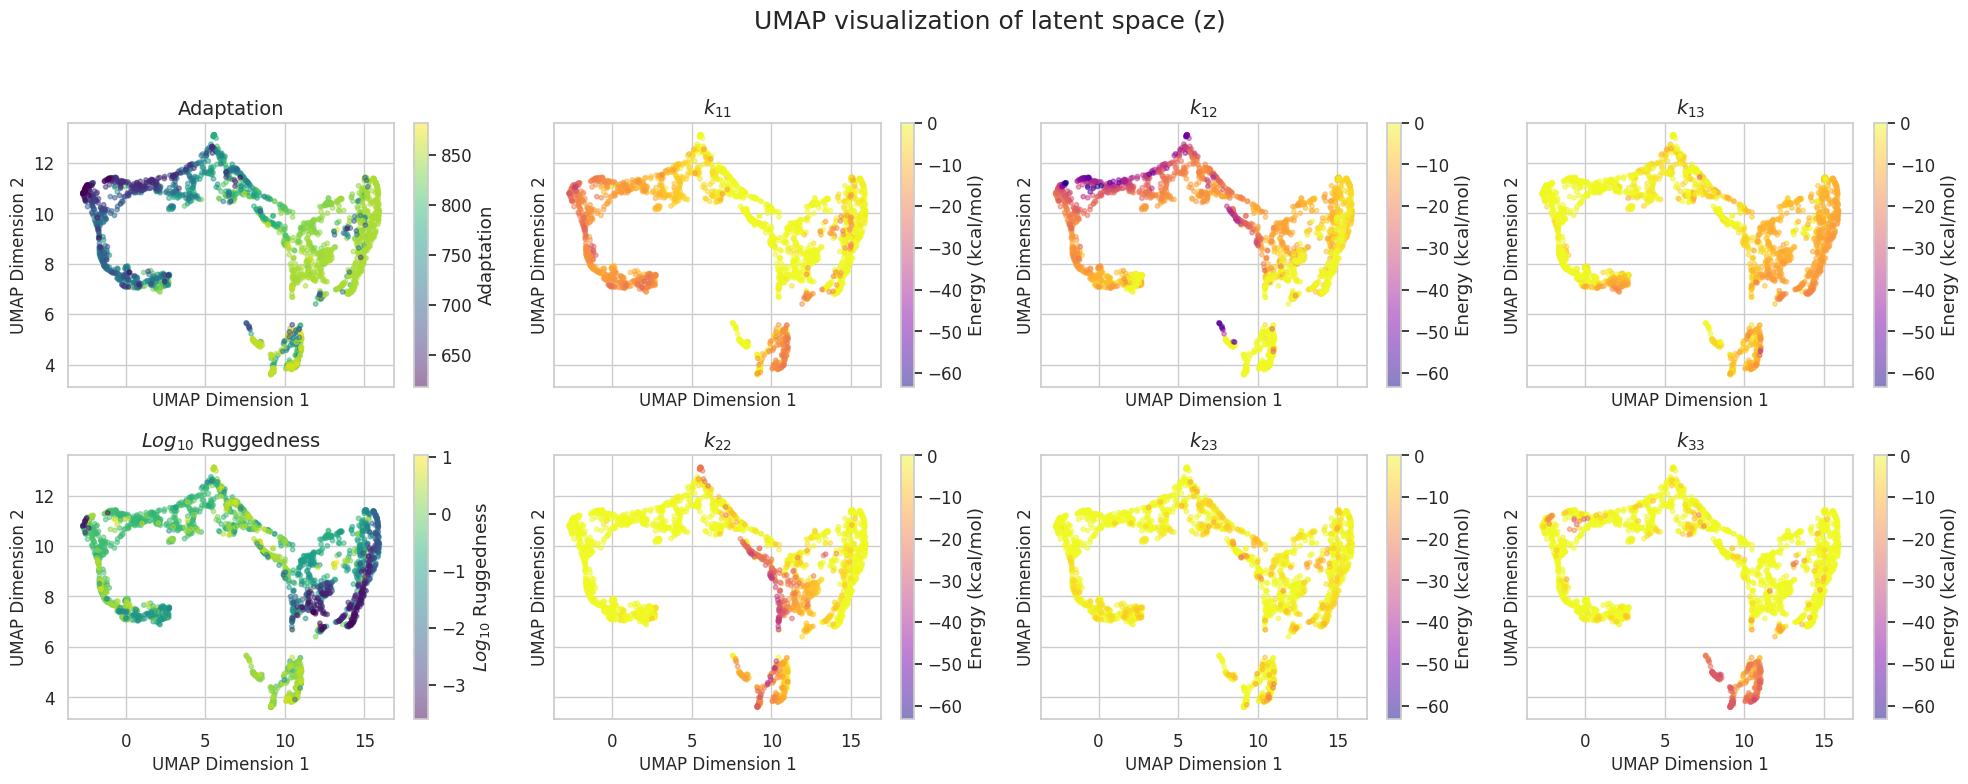

In [22]:
def visualize_dimred_2d_custom_labels(dimred_result, cond, x_bin, labels_cond, labels_x: list, method='TSNE', save_path=None, use_z=True):
    
    sns.set_style('whitegrid')
    
    ncols = 4 if len(labels_cond) > 1 else (x_bin.shape[-1] + 1)
    nrows = len(labels_cond)
    fig, axes = plt.subplots(nrows, ncols, figsize=(
        5*ncols, 4*nrows), sharex=True, sharey=True)
    if nrows == 1:
        axes = axes[None, :]

    # Cond plots on the left
    for i, l in enumerate(labels_cond):
        ax_main = fig.add_subplot(axes[i, 0])  # Span both rows
        # idxs_hue = np.argsort(cond[:, i])[::-1]
        # idxs_hue[:len(idxs_hue)//2] = idxs_hue[:len(idxs_hue)//2][::-1]
        idxs_hue = make_sort_hue(cond[:, i], sort=True, sort_random=False, sort_flip_prop=4)
        scatter = ax_main.scatter(
            dimred_result[idxs_hue, 0], dimred_result[idxs_hue, 1], c=cond[idxs_hue, i], cmap='viridis', alpha=0.5, s=10)
        ax_main.set_title(
            l.capitalize() if not "ruggedness" in l else r'$Log_{10}$ Ruggedness', fontsize=14)
        ax_main.set_xlabel(f'{method} Dimension 1', fontsize=12)
        ax_main.set_ylabel(f'{method} Dimension 2', fontsize=12)
        plt.colorbar(scatter, ax=ax_main, label=l.capitalize() if not "ruggedness" in l else r'$Log_{10}$ Ruggedness')

    # Interaction plots on the right
    for i in range(x_bin.shape[-1]):
        row = i // (ncols-1)
        col = i % (ncols-1) + 1
        ax = fig.add_subplot(axes[row, col])
        # idxs_hue = np.argsort(x_bin[:, i])[::-1]
        # idxs_hue[:len(idxs_hue)//2] = idxs_hue[:len(idxs_hue)//2][::-1]
        idxs_hue = make_sort_hue(x_bin[:, i], sort=True, sort_random=False, sort_flip_prop=4)
        scatter = ax.scatter(
            dimred_result[idxs_hue, 0], dimred_result[idxs_hue, 1], c=x_bin[idxs_hue, i], cmap='plasma', alpha=0.5, s=10)
        ax.set_title(labels_x[i], fontsize=14)
        ax.set_xlabel(f'{method} Dimension 1', fontsize=12)
        ax.set_ylabel(f'{method} Dimension 2', fontsize=12)
        scatter.set_clim(np.nanmin(x_bin), np.nanmax(x_bin))
        # if i == (x_bin.shape[-1] - 1):
        plt.colorbar(scatter, ax=ax, label=f'Energy (kcal/mol)')

    plt.suptitle(f'{method} visualization of latent space ({"z" if use_z else "h"})', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()


# cond_rev_all = np.concatenate([np.array(analytics_show[k])[
#                               :, output_idx, None] for k in labels_chosen_a], axis=-1)
visualize_dimred_2d_custom_labels(umap_result, cond_rev_all[idxs_show], all_fake_circuits_flat[idxs_show],
                                  labels_cond=labels_chosen_a,
                                  labels_x=labels_x, method=method, save_path=os.path.join(top_write_dir, 'umap.png'),
                                  use_z=use_z)

/tmp/ipykernel_9410/2941252098.py:18: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipykernel_9410/2941252098.py:18: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0, 0, 1, 0.95])


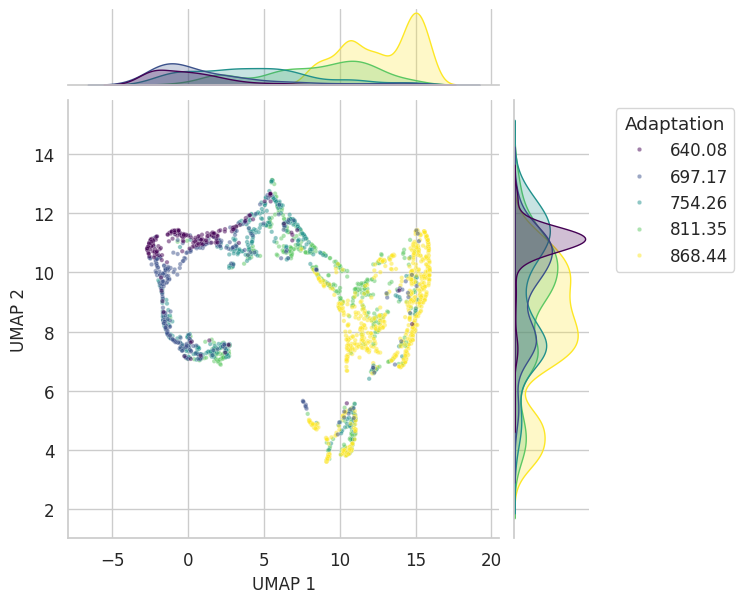

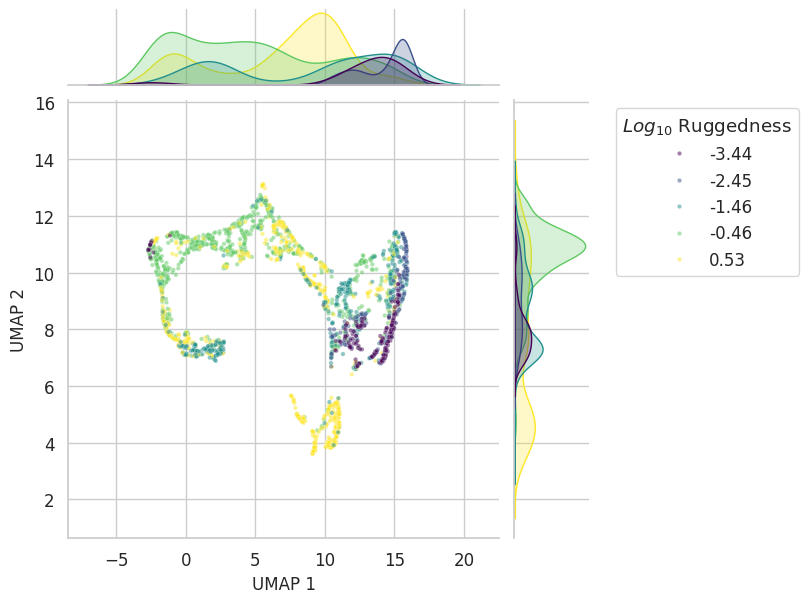

In [23]:
# cond_binned = cond_rev_all
# if not hpos.loc['prep_y_categorical']:
#     for i in range(len(config_dataset.objective_col)):
#         cond_binned[..., i] = bin_array(
#             cond_rev_all[..., i], num_bins=5)[0].round(2)
        
for i, l in enumerate(labels_chosen_a):
    # idxs_hue = np.argsort(cond_rev_all[idxs_show][:, i])[::-1]
    # idxs_hue[:len(idxs_hue)//2] = idxs_hue[:len(idxs_hue)//2][::-1]
    idxs_hue = make_sort_hue(cond_binned[idxs_show][:, i], sort=True, sort_random=False, sort_flip_prop=4)
    g = sns.jointplot(
        x=umap_result[idxs_hue, 0], y=umap_result[idxs_hue, 1], hue=cond_binned[idxs_show][idxs_hue, i], palette='viridis', alpha=0.5, s=10)
    # plt.legend(title='\n('.join(l.capitalize().split(' (')))
    sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.25, 1), title=l.capitalize() if 'ruggedness' not in l else r'$Log_{10}$ Ruggedness')
    plt.xlabel(f'{method} 1', fontsize=12)
    plt.ylabel(f'{method} 2', fontsize=12)
    # plt.suptitle(l.capitalize(), fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(top_write_dir, f'umap_joint_{str(i)}.png'), dpi=300, bbox_inches='tight', transparent=True)

# Plot motifs from UMAP

In [24]:
fn_ys = os.path.join(dir_src_rugg, 'ys.npy')

if os.path.exists(fn_ys):
    ys = np.load(fn_ys)
    ts = np.load(os.path.join(dir_src_rugg, 'ts.npy'))

/tmp/ipykernel_9410/4246952705.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'High Ruggedness' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  umap_result_df.loc[umap_result_df['UMAP 1'].between(
/tmp/ipykernel_9410/4246952705.py:51: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(umap_result_df[umap_result_df['Selected']], x='UMAP 1',
/tmp/ipykernel_9410/4246952705.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout() #rect=[0, 0, 1, 0.95])


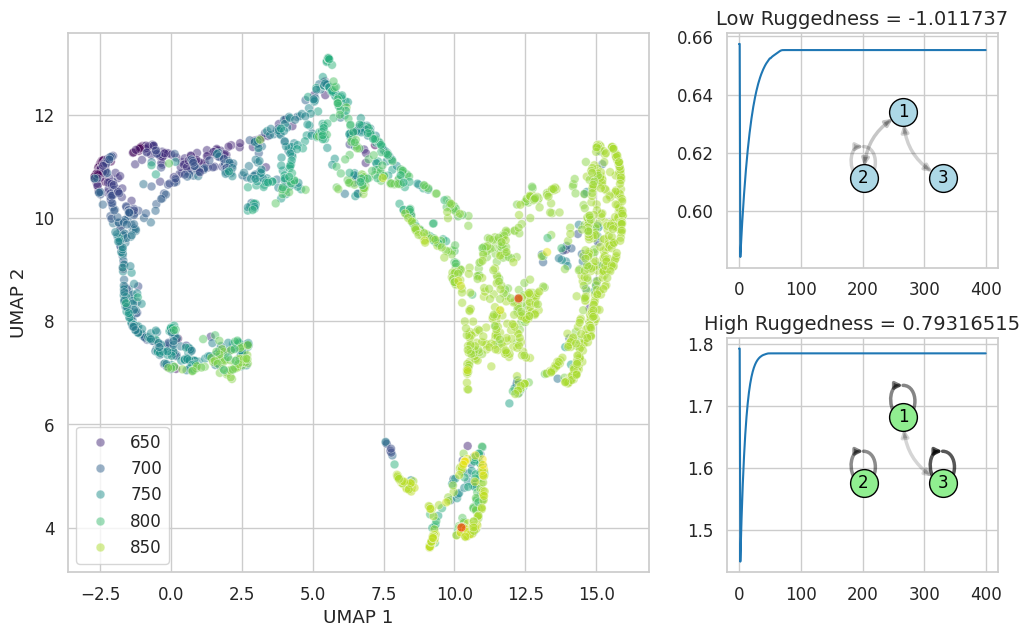

In [45]:
umap_result_df = pd.DataFrame(umap_result, columns=['UMAP 1', 'UMAP 2'])
umap_result_df['Log sensitivity'] = analytics_show['Log sensitivity'][idxs_show, idx_output]
umap_result_df['Log precision'] = analytics_og['Log precision'][idxs_show, idx_output]
umap_result_df['adaptation'] = analytics_show['adaptation'][idxs_show, idx_output]
umap_result_df['overshoot'] = analytics_og['overshoot'][idxs_show, idx_output]
umap_result_df['initial_steady_states'] = analytics_og['initial_steady_states'][idxs_show, idx_output]
umap_result_df['response_time'] = analytics_og['response_time'][idxs_show, idx_output]
umap_result_df['overshoot/initial'] = umap_result_df['overshoot'] / umap_result_df['initial_steady_states']
umap_result_df[k_rugg] = analytics_show[k_rugg][idxs_show, idx_output]
umap_result_df[x_cols] = all_fake_circuits_flat[idxs_show]
umap_result_df['Cluster'] = np.nan
umap_result_df['Selected'] = False
umap_result_df['Is adaptable'] = False

umap_xy_hirugg = [[8, 12], [3, 5.5]]
umap_xy_lorugg = [[11, 16], [6.5, 8.5]]
umap_result_df.loc[umap_result_df['UMAP 1'].between(
    *umap_xy_hirugg[0]) & umap_result_df['UMAP 2'].between(*umap_xy_hirugg[1]), 'Cluster'] = 'High Ruggedness'
umap_result_df.loc[umap_result_df['UMAP 1'].between(
    *umap_xy_lorugg[0]) & umap_result_df['UMAP 2'].between(*umap_xy_lorugg[1]), 'Cluster'] = 'Low Ruggedness'
umap_result_df.loc[(umap_result_df['overshoot'] > 0.01)
                   & (umap_result_df['adaptation'] >= 820) 
                #    & (umap_result_df['Log sensitivity'] >= -1) 
                #    & (umap_result_df['Log precision'] >= -1) 
                #    & (umap_result_df['overshoot/initial'] > 0.3)
                #    & (umap_result_df['response_time'] < 1000)
                   , 'Is adaptable'] = True

idxs_adaptable_hirugg = umap_result_df[(umap_result_df['Cluster'] == 'High Ruggedness') & (
    umap_result_df['Is adaptable'])].sort_values(by=k_rugg, ascending=False).index[0]
idxs_adaptable_lorugg = umap_result_df[(umap_result_df['Cluster'] == 'Low Ruggedness') & (
    umap_result_df['Is adaptable'])].sort_values(by=k_rugg, ascending=True).index[8]
umap_result_df.loc[idxs_adaptable_hirugg, 'Selected'] = True
umap_result_df.loc[idxs_adaptable_lorugg, 'Selected'] = True


sns.set_style('whitegrid')
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(2, 3, width_ratios=[6, 1, 1], height_ratios=[1, 1], wspace=0.3, hspace=0.3)

# Big subplot on the left
ax_big = fig.add_subplot(gs[:, 0])

# Two smaller subplots on the right
ax_top = fig.add_subplot(gs[0, 1:])
ax_bottom = fig.add_subplot(gs[1, 1:])


sns.scatterplot(umap_result_df, x='UMAP 1', y='UMAP 2', hue='adaptation',  # k_rugg, #
                palette='viridis', alpha=0.5, s=40, ax=ax_big)
sns.scatterplot(umap_result_df[umap_result_df['Selected']], x='UMAP 1',
                y='UMAP 2', color='r', palette='viridis', alpha=0.5, s=40, ax=ax_big)

for ax, c, pos in zip([ax_top, ax_bottom], ['Low Ruggedness', 'High Ruggedness'], [(0.2, 0.1), (0.2, 0.1)]):
    filt = umap_result_df['Selected'] & (umap_result_df['Cluster'] == c)
    w = np.median(umap_result_df[filt][x_cols].values, axis=0)
    sns.lineplot(ys[idxs_show][umap_result_df[filt].index[0], :, idxs_output], ax=ax)
    create_network_inset(fig, ax, pos=pos, width=0.9, height=0.9, edge_weights=make_nx_weights(w, n_nodes=3, vmin=-30, vmax=0),
                        node_color='lightgreen' if 'High' in c else 'lightblue', linewidth=2.5)
    ax.set_title(c + ' = ' + str(umap_result_df[filt][k_rugg].iloc[0]), fontsize=14)

plt.tight_layout() #rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'umap_hiloruggs.png'), dpi=300, bbox_inches='tight', transparent=True)

In [55]:
all_fake_circuits_flat[i]

array([ 1.5603087e-05, -1.3499790e+01, -1.1179275e+01, -5.6597819e+00,
        4.6733448e-06,  1.3479726e-05], dtype=float32)

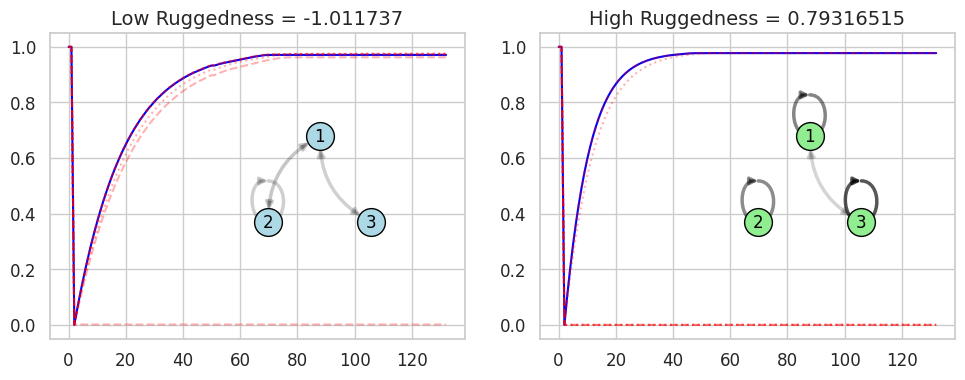

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=False)

for ax, c, pos in zip(axs, ['Low Ruggedness', 'High Ruggedness'], [(0.2, 0.1), (0.2, 0.1)]):
    
    filt = umap_result_df['Selected'] & (umap_result_df['Cluster'] == c)
    i = idxs_show[umap_result_df[filt].index[0]]
    for crugg in range(n_perturbs):
        ip = i + crugg
        ys_p = ys[ip][:ys.shape[1]//3, idxs_output]
        sns.lineplot((ys_p - ys_p.min()) / (ys_p - ys_p.min()).max(), 
                     ax=ax, alpha = 1 if crugg == 0 else 0.3,
                     linestyle=('--' if np.mod(crugg, 2) == 0 else 'dotted') if crugg > 0 else '-',
                     color='b' if crugg == 0 else 'r')

    w = all_fake_circuits_flat[i]
    create_network_inset(fig, ax, pos=pos, width=0.9, height=0.9, edge_weights=make_nx_weights(w, n_nodes=3, vmin=-30, vmax=0),
                        node_color='lightgreen' if 'High' in c else 'lightblue', linewidth=2.5)
    ax.set_title(c + ' = ' + str(umap_result_df[filt][k_rugg].iloc[0]), fontsize=14)

plt.tight_layout() #rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'umap_hiloruggs_times.png'), dpi=300, bbox_inches='tight', transparent=True)

In [50]:
idxs_show[umap_result_df[filt].index[0]]

np.int64(39568)

((194, 6), (100000, 6))

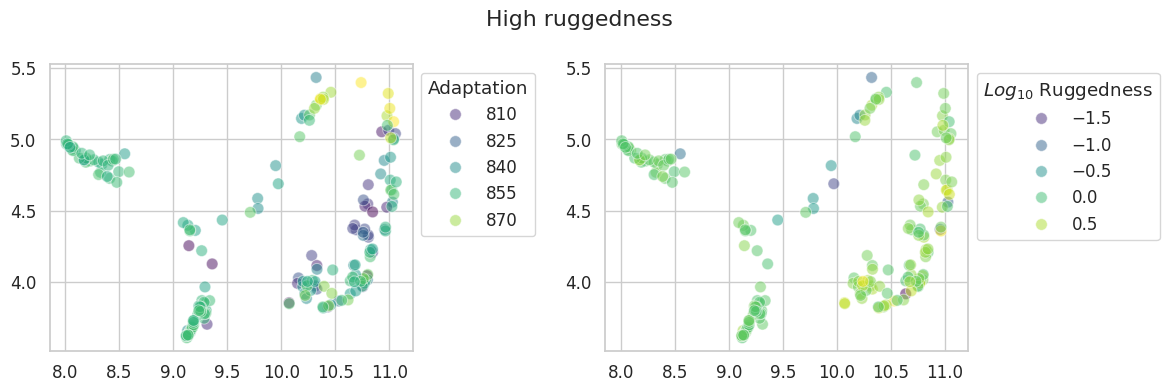

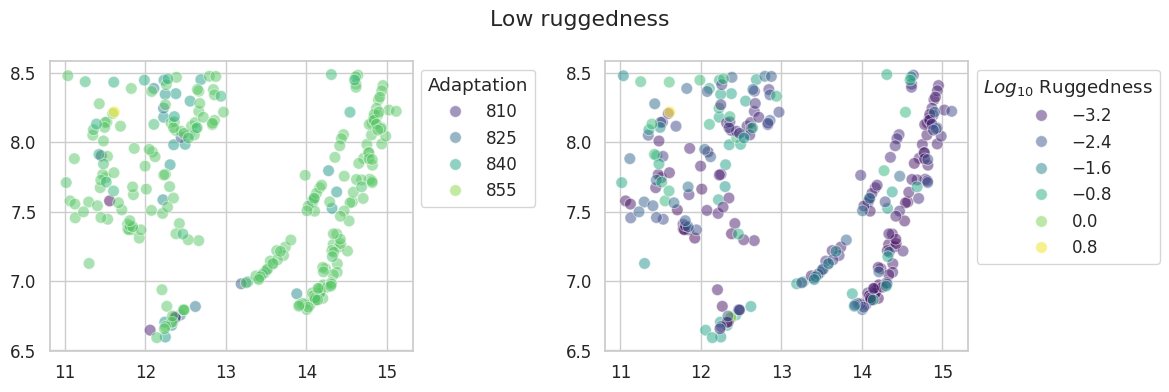

In [73]:
idxs_adaptable_lorugg = np.where((umap_result[:, 0] > umap_xy_lorugg[0][0]) & (umap_result[:, 0] < umap_xy_lorugg[0][1]) &
                         (umap_result[:, 1] > umap_xy_lorugg[1][0]) & (umap_result[:, 1] < umap_xy_lorugg[1][1]) & 
                         (cond_rev_all[idxs_show][:, 0] > 800))
idxs_adaptable_hirugg = np.where((umap_result[:, 0] > umap_xy_hirugg[0][0]) & (umap_result[:, 0] < umap_xy_hirugg[0][1]) &
                         (umap_result[:, 1] > umap_xy_hirugg[1][0]) & (umap_result[:, 1] < umap_xy_hirugg[1][1]) & 
                         (cond_rev_all[idxs_show][:, 0] > 800))
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
g = sns.scatterplot(x=umap_result[idxs_adaptable_hirugg, 0].squeeze(), y=umap_result[idxs_adaptable_hirugg, 1].squeeze(), hue=cond_rev_all[idxs_show][idxs_adaptable_hirugg, 0].squeeze(), palette='viridis', alpha=0.5, s=70, ax=axs[0])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title='Adaptation')
g = sns.scatterplot(x=umap_result[idxs_adaptable_hirugg, 0].squeeze(), y=umap_result[idxs_adaptable_hirugg, 1].squeeze(), hue=cond_rev_all[idxs_show][idxs_adaptable_hirugg, 1].squeeze(), palette='viridis', alpha=0.5, s=70, ax=axs[1])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title=r'$Log_{10}$ Ruggedness')
plt.suptitle('High ruggedness')
plt.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
g = sns.scatterplot(x=umap_result[idxs_adaptable_lorugg, 0].squeeze(), y=umap_result[idxs_adaptable_lorugg, 1].squeeze(), hue=cond_rev_all[idxs_show][idxs_adaptable_lorugg, 0].squeeze(), palette='viridis', alpha=0.5, s=70, ax=axs[0])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title='Adaptation')
g = sns.scatterplot(x=umap_result[idxs_adaptable_lorugg, 0].squeeze(), y=umap_result[idxs_adaptable_lorugg, 1].squeeze(), hue=cond_rev_all[idxs_show][idxs_adaptable_lorugg, 1].squeeze(), palette='viridis', alpha=0.5, s=70, ax=axs[1])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title=r'$Log_{10}$ Ruggedness')
plt.suptitle('Low ruggedness')
plt.tight_layout()

all_fake_circuits_flat[idxs_show][idxs_adaptable_hirugg].shape, all_fake_circuits_flat.shape

In [74]:
n_species = 3
# cols_e = sorted(set([hpos['x_type'] + '_' + '-'.join(sorted([str(i + 1), str(j + 1)]))
#                 for i, j in itertools.product(range(3), range(3))]))
cols_e = [r'$k_{' + str(i) + str(j) + '}$' for i, j in sorted(set([tuple(sorted(i)) for i in itertools.product(np.arange(n_species) + 1, np.arange(n_species) + 1)]))]


### Low ruggedness adaptable circuits clusters

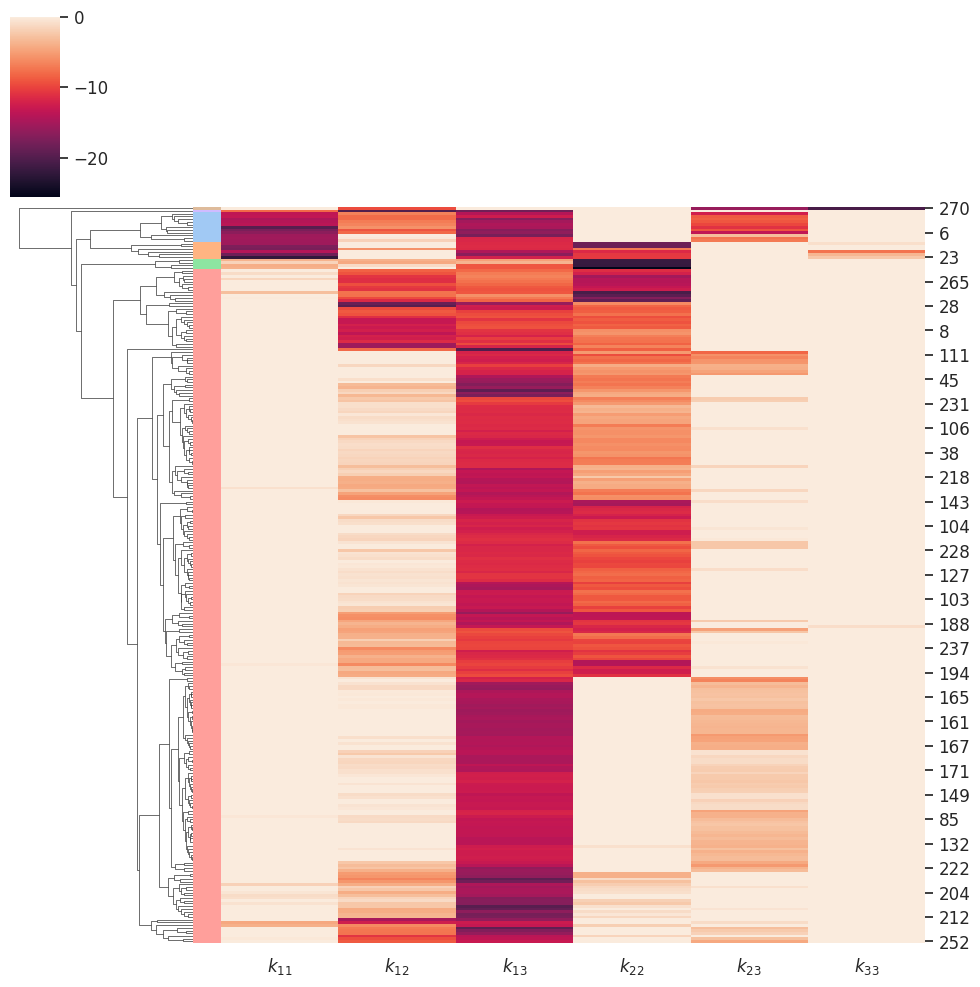

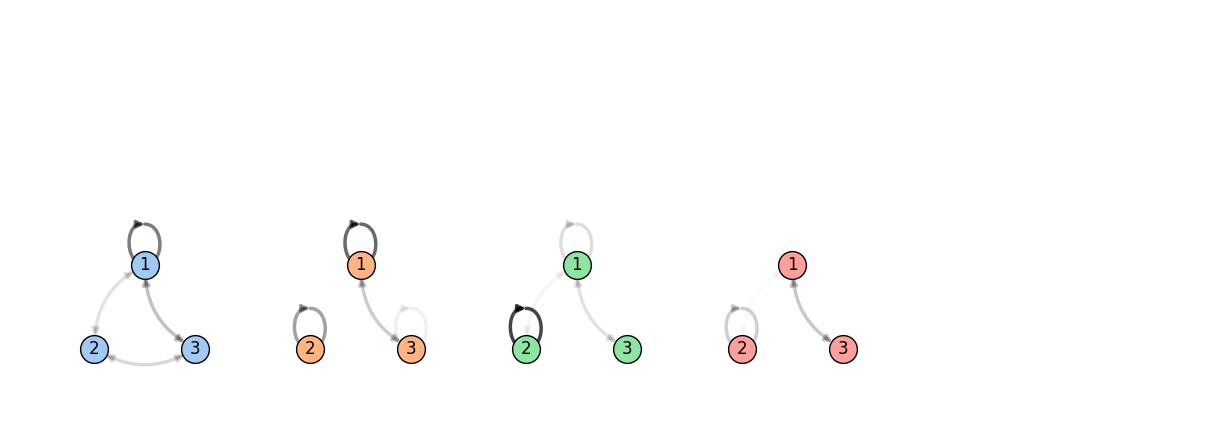

In [75]:
def plot_cluster(row_colors, idxs):
    g = sns.clustermap(pd.DataFrame(all_fake_circuits_flat[idxs_show][idxs], columns=cols_e), col_cluster=False, row_colors=row_colors
                    )
    n_clusters = 6
    row_linkage = g.dendrogram_row.linkage
    clusters = fcluster(row_linkage, t=n_clusters, criterion='maxclust')
    
    if row_colors is None:
        plt.close()
        del g

    lut = dict(zip(sorted(pd.Series(clusters).unique()),
            sns.color_palette('pastel', n_clusters).as_hex()))
    row_colors = pd.Series(clusters).map(lut).to_numpy()
    
    return row_colors, clusters, n_clusters
    
    
row_colors = None
row_colors, clusters, n_clusters = plot_cluster(row_colors, idxs_adaptable_lorugg)
row_colors, clusters, n_clusters = plot_cluster(row_colors, idxs_adaptable_lorugg)

fig, ax = plt.subplots(figsize=(15, 5))
d_lo = pd.DataFrame()
# cols_e = sorted(set([hpos['x_type'] + '_' + '-'.join(sorted([str(i + 1), str(j + 1)]))
#                 for i, j in itertools.product(range(3), range(3))]))
d_lo['Cluster'] = clusters
d_lo[cols_e] = all_fake_circuits_flat[idxs_show][idxs_adaptable_lorugg]
for i, c in enumerate(labels_chosen_a):
    d_lo[c] = cond_rev_all[idxs_show][idxs_adaptable_lorugg, i].squeeze()
pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1) - 0.2) * 1.3,
                     np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
colors = sns.color_palette('pastel', n_clusters).as_hex()
d_lo = d_lo[d_lo['Cluster'].apply(lambda x: np.where(clusters == x, 1, 0).sum() > 2)]
for i, c in enumerate(sorted(d_lo['Cluster'].unique())):
    fake_circuits_cluster = d_lo[d_lo['Cluster']
                                    == c][cols_e].values
    w = np.median(fake_circuits_cluster, axis=0)
    create_network_inset(fig, ax,
                         pos=pos[i],
                         width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                             vmin=-30, #np.nanmin(all_fake_circuits_flat[idxs_show]), 
                                                                             vmax=0), # np.nanmax(all_fake_circuits_flat[idxs_show]),),
                         node_color=colors[c-1], linewidth=2.5)
ax.set_axis_off()
plt.savefig(os.path.join(top_write_dir, 'motifs_adapt_lorugg.png'), dpi=300, bbox_inches='tight', transparent=True)

In [76]:
d_lo.groupby('Cluster')[labels_chosen_a].agg(['min', 'mean', 'std', 'count']).T

Cluster                                     1           2           3  \
adaptation                  min    820.271484  806.214539  842.302734   
                            mean   832.238464  828.233948  846.164001   
                            std      4.705615   11.237414    3.063039   
                            count   11.000000    6.000000    4.000000   
Log ruggedness (adaptation) min     -1.305831   -1.074897   -1.300369   
                            mean    -1.050527   -1.013776   -0.892624   
                            std      0.090538    0.044935    0.436897   
                            count   11.000000    6.000000    4.000000   

Cluster                                     4  
adaptation                  min    801.540161  
                            mean   847.844971  
                            std      5.333874  
                            count  248.000000  
Log ruggedness (adaptation) min     -3.604226  
                            mean    -2.597432  
                            std      0.893229  
                            count  248.000000

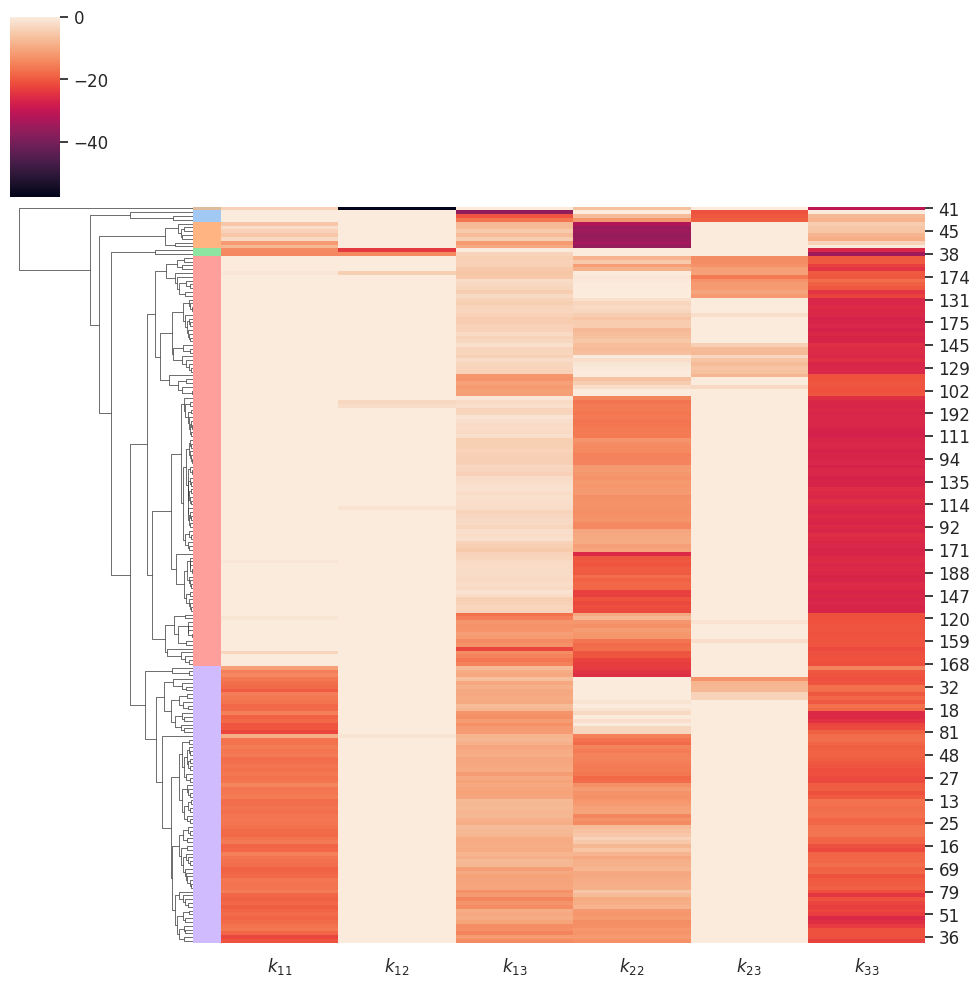

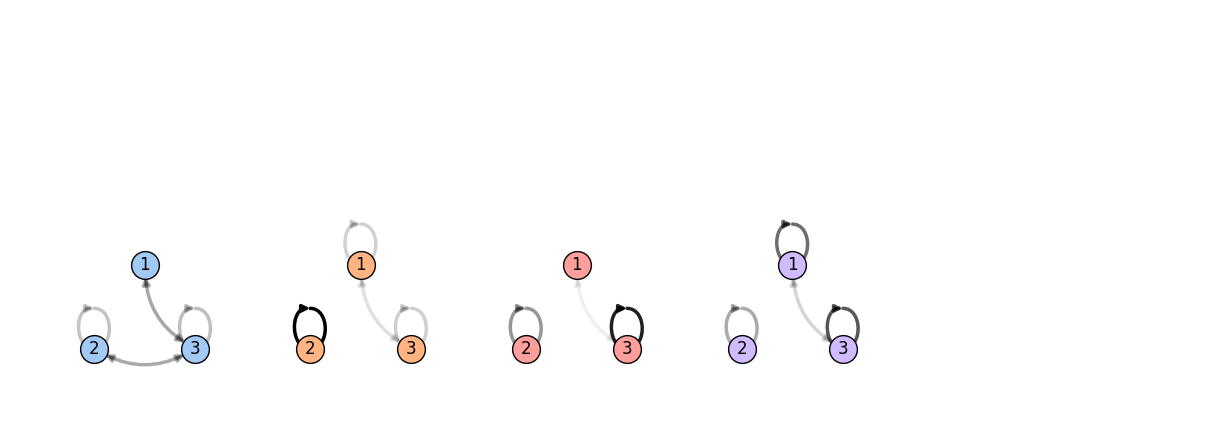

In [77]:
def plot_cluster(row_colors, idxs):
    g = sns.clustermap(pd.DataFrame(all_fake_circuits_flat[idxs_show][idxs], columns=cols_e), col_cluster=False, row_colors=row_colors
                    )
    n_clusters = 6
    row_linkage = g.dendrogram_row.linkage
    clusters = fcluster(row_linkage, t=n_clusters, criterion='maxclust')
    
    if row_colors is None:
        plt.close()
        del g

    lut = dict(zip(sorted(pd.Series(clusters).unique()),
            sns.color_palette('pastel', n_clusters).as_hex()))
    row_colors = pd.Series(clusters).map(lut).to_numpy()
    
    return row_colors, clusters, n_clusters
    
    
row_colors = None
row_colors, clusters, n_clusters = plot_cluster(row_colors, idxs_adaptable_hirugg)
row_colors, clusters, n_clusters = plot_cluster(row_colors, idxs_adaptable_hirugg)


fig, ax = plt.subplots(figsize=(15, 5))
d_hi = pd.DataFrame()
# cols_e = sorted(set([hpos['x_type'] + '_' + '-'.join(sorted([str(i + 1), str(j + 1)]))
#                 for i, j in itertools.product(range(3), range(3))]))
d_hi['Cluster'] = clusters
d_hi[cols_e] = all_fake_circuits_flat[idxs_show][idxs_adaptable_hirugg]
for i, c in enumerate(labels_chosen_a):
    d_hi[c] = cond_rev_all[idxs_show][idxs_adaptable_hirugg, i].squeeze()
pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1) - 0.2) * 1.3,
                     np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
colors = sns.color_palette('pastel', n_clusters).as_hex()
d_hi = d_hi[d_hi['Cluster'].apply(lambda x: np.where(clusters == x, 1, 0).sum() > 2)]
for i, c in enumerate(sorted(d_hi['Cluster'].unique())):
    fake_circuits_cluster = d_hi[d_hi['Cluster']
                                    == c][cols_e].values
    w = np.median(fake_circuits_cluster, axis=0)
    create_network_inset(fig, ax,
                         pos=pos[i],
                         width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                             vmin=-30, #np.nanmin(all_fake_circuits_flat[idxs_show]), 
                                                                             vmax=0), # np.nanmax(all_fake_circuits_flat[idxs_show]),),
                         node_color=colors[c-1], linewidth=2.5)
ax.set_axis_off()
plt.savefig(os.path.join(top_write_dir, 'motifs_adapt_hirugg.png'), dpi=300, bbox_inches='tight', transparent=True)

In [78]:
d_hi.groupby('Cluster')[labels_chosen_a].agg(['mean', 'std', 'count']).T

Cluster                                     1           2           4  \
adaptation                  mean   854.365051  842.452332  857.459351   
                            std      2.741880    3.883718    7.925013   
                            count    3.000000    7.000000  108.000000   
Log ruggedness (adaptation) mean     0.158562   -0.678444    0.179594   
                            std      0.075508    0.335463    0.124015   
                            count    3.000000    7.000000  108.000000   

Cluster                                     5  
adaptation                  mean   835.512939  
                            std     20.441004  
                            count   73.000000  
Log ruggedness (adaptation) mean     0.296900  
                            std      0.304796  
                            count   73.000000

# Specific circuits

In [79]:
# df_plot = pd.DataFrame()
# df_plot['UMAP 1'] = umap_result[:, 0]
# df_plot['UMAP 2'] = umap_result[:, 1]
# for i, l in enumerate(labels_chosen_a):
#     df_plot[l] = cond_binned[idxs_show][:, i]
    

### High adaptation, low ruggedness

In [80]:
df_rugg['overshoot'] = analytics_og['overshoot'][..., idx_output]
df_rugg['initial_steady_states'] = analytics_og['initial_steady_states'][..., idx_output]
df_rugg['steady_states'] = analytics_og['steady_states'][..., idx_output]
df_rugg['Adaptation bin'] = pd.cut(
    df_rugg['Adaptation'], bins=10)
df_rugg['Adaptation bin'] = df_rugg['Adaptation bin'].apply(
    lambda x: x.mid).astype(float).round(2)
df_rugg.loc[np.isinf(df_rugg['Log precision']), 'Log precision'] = np.nan
df_rugg['Is adaptable'] = False
df_rugg['Is adaptable og'] = False
df_rugg.loc[(df_rugg['Log sensitivity'] > 1) & (df_rugg['Log precision'] > 0), 'Is adaptable og'] = True # np.nanmax(df_rugg['Adaptation bin']) + 20
df_rugg.loc[df_rugg['Adaptation'] > 875, 'Is adaptable'] = True # np.nanmax(df_rugg['Adaptation bin']) + 20

# df_rugg.sort_values(by=['Adaptation bin', 'Log ruggedness (adaptation)'], ascending=False)

In [81]:
data['Is adaptable'] = False
data['Is adaptable og'] = False
data.loc[(data['Log sensitivity'] > 1) & (data['Log precision'] > 0), 'Is adaptable og'] = True # np.nanmax(data['Adaptation bin']) + 20
data.loc[data['adaptation'] > 875, 'Is adaptable'] = True # np.nanmax(data['Adaptation bin']) + 20


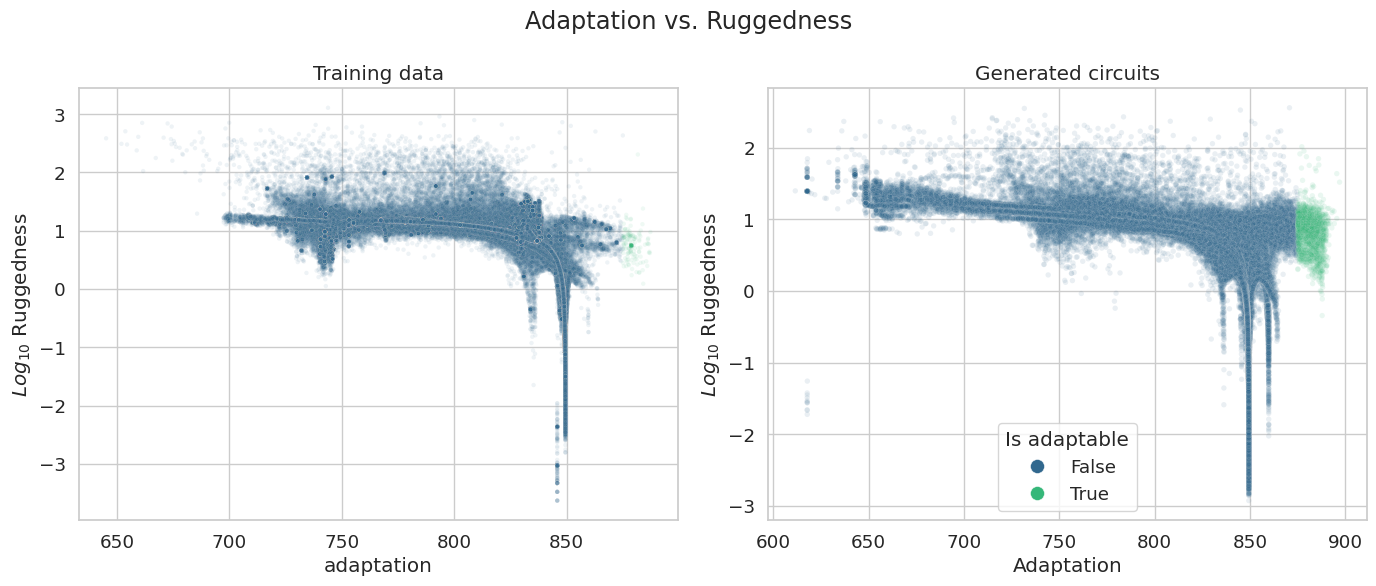

In [82]:
hue = 'initial_steady_states'
hue = 'steady_states' 
hue = 'overshoot'
hue = 'Is adaptable'

sns.set_context('notebook', font_scale=1.2)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

g = sns.scatterplot(data.sort_values(by=hue), x='adaptation', y='Log ruggedness (adaptation)',
                    hue=hue, alpha=0.08,
                    palette='viridis', s=10, ax=axs[0], legend=False)
axs[0].set_title('Training data')
axs[0].set_ylabel(r'$Log_{10}$ Ruggedness')

g = sns.scatterplot(df_rugg.sort_values(by=hue), x='Adaptation', y='Log ruggedness (adaptation)',
                    hue=hue, alpha=0.1,
                    palette='viridis', s=15, ax=axs[1])
axs[1].set_title('Generated circuits')
axs[1].set_ylabel(r'$Log_{10}$ Ruggedness')
for line in g.legend().get_lines():
    line.set(alpha=1.0, markersize=10)
g.legend_.set_title(hue)
sns.move_legend(g, "lower center", title=hue)  # bbox_to_anchor=(1, 1), 

plt.suptitle('Adaptation vs. Ruggedness')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'adaptation_ruggedness.png'), dpi=300, bbox_inches='tight', transparent=True)

### Adaptable high + low motifs from all data, not just UMAP 

In [83]:
# filt_adaptable = df_rugg['Is adaptable']
filt_adaptable = (df_rugg['Log sensitivity'] > 1) & (df_rugg['Log precision'] > 0) & (df_rugg['overshoot'] > 0.01)
idxs_adaptable = df_rugg[filt_adaptable].index.to_list()
filt_adaptable_lorugg = filt_adaptable & (df_rugg['Log ruggedness (adaptation)'] <= 0.5)
filt_adaptable_hirugg = filt_adaptable & (df_rugg['Log ruggedness (adaptation)'] > 0.5)
idxs_adaptable_lorugg2 = df_rugg[filt_adaptable_lorugg].index.to_list()
idxs_adaptable_hirugg2 = df_rugg[filt_adaptable_hirugg].index.to_list()


/tmp/ipykernel_9410/1234494209.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g2 = sns.violinplot(data=df_plot, x='Cluster',
/tmp/ipykernel_9410/1234494209.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


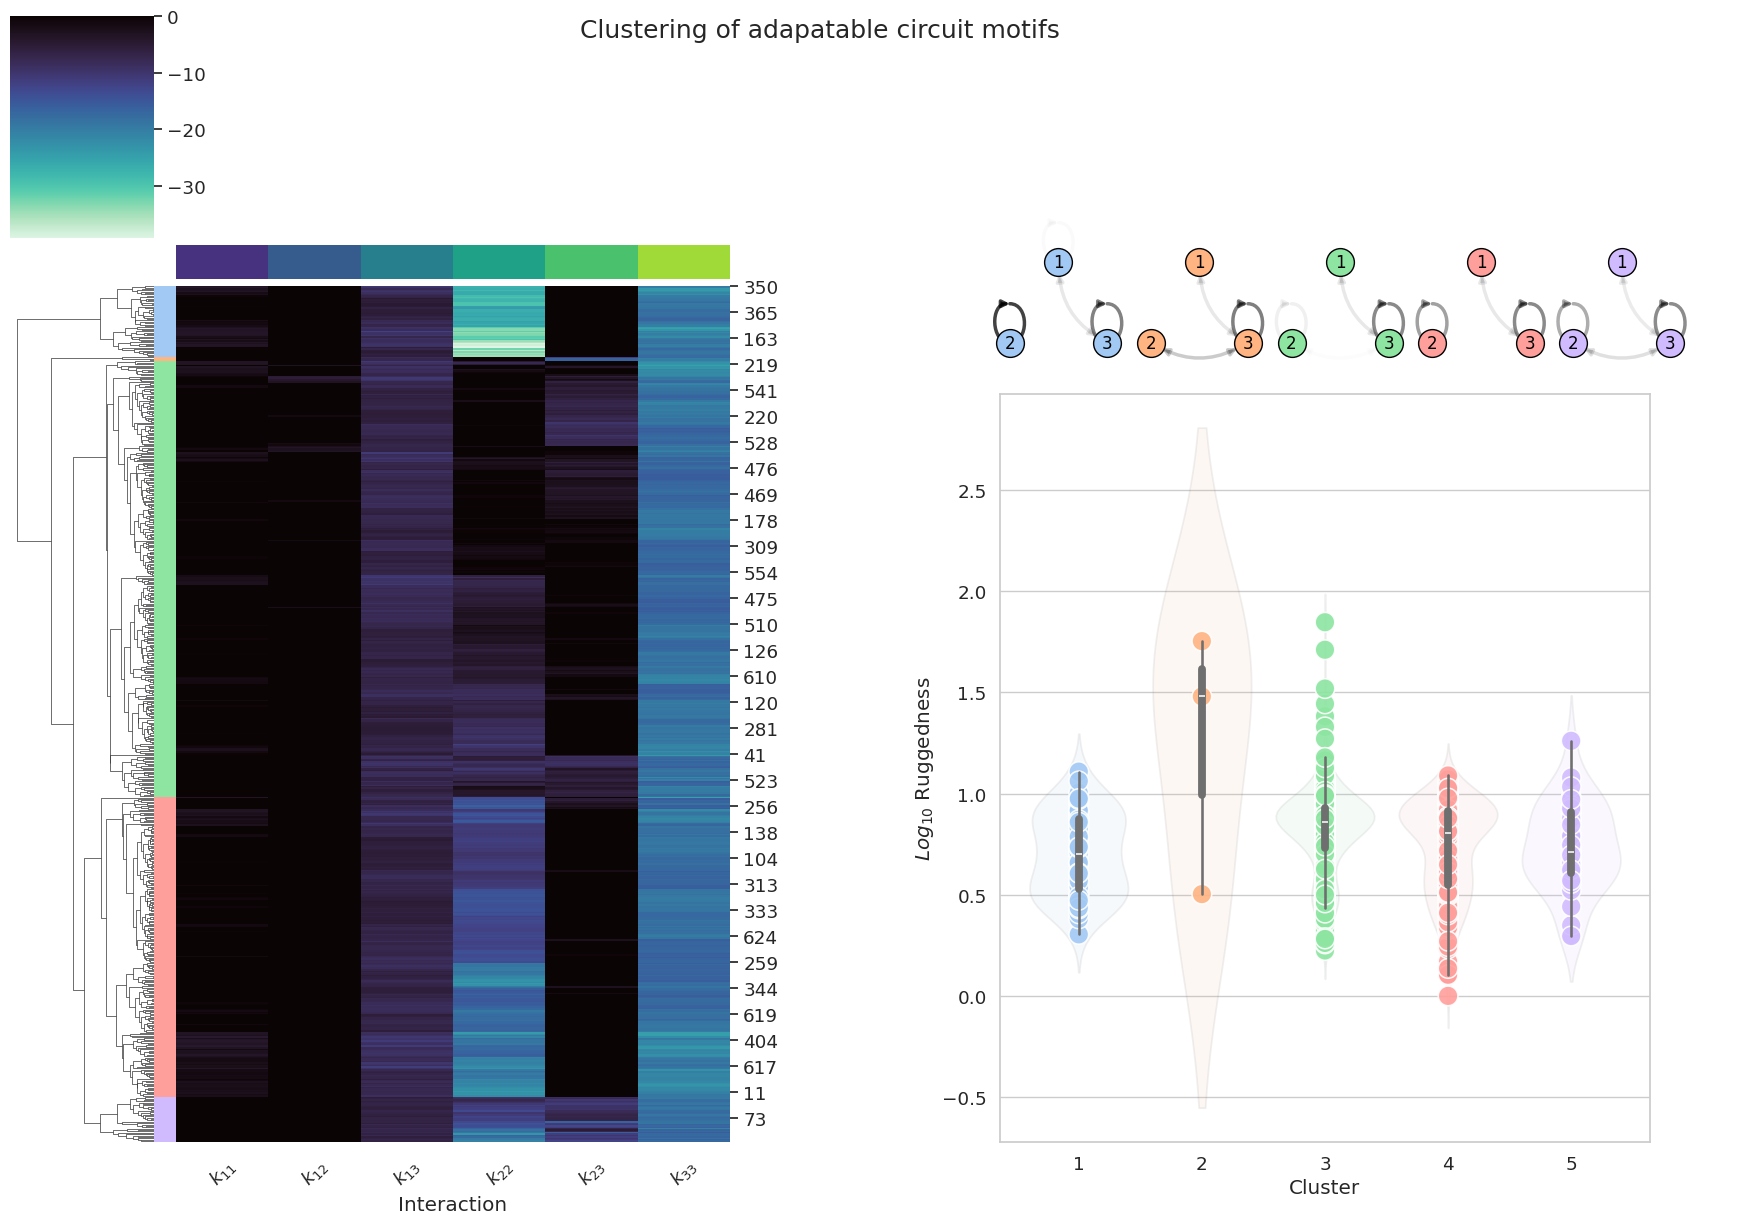

/tmp/ipykernel_9410/1234494209.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g2 = sns.violinplot(data=df_plot, x='Cluster',
/tmp/ipykernel_9410/1234494209.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


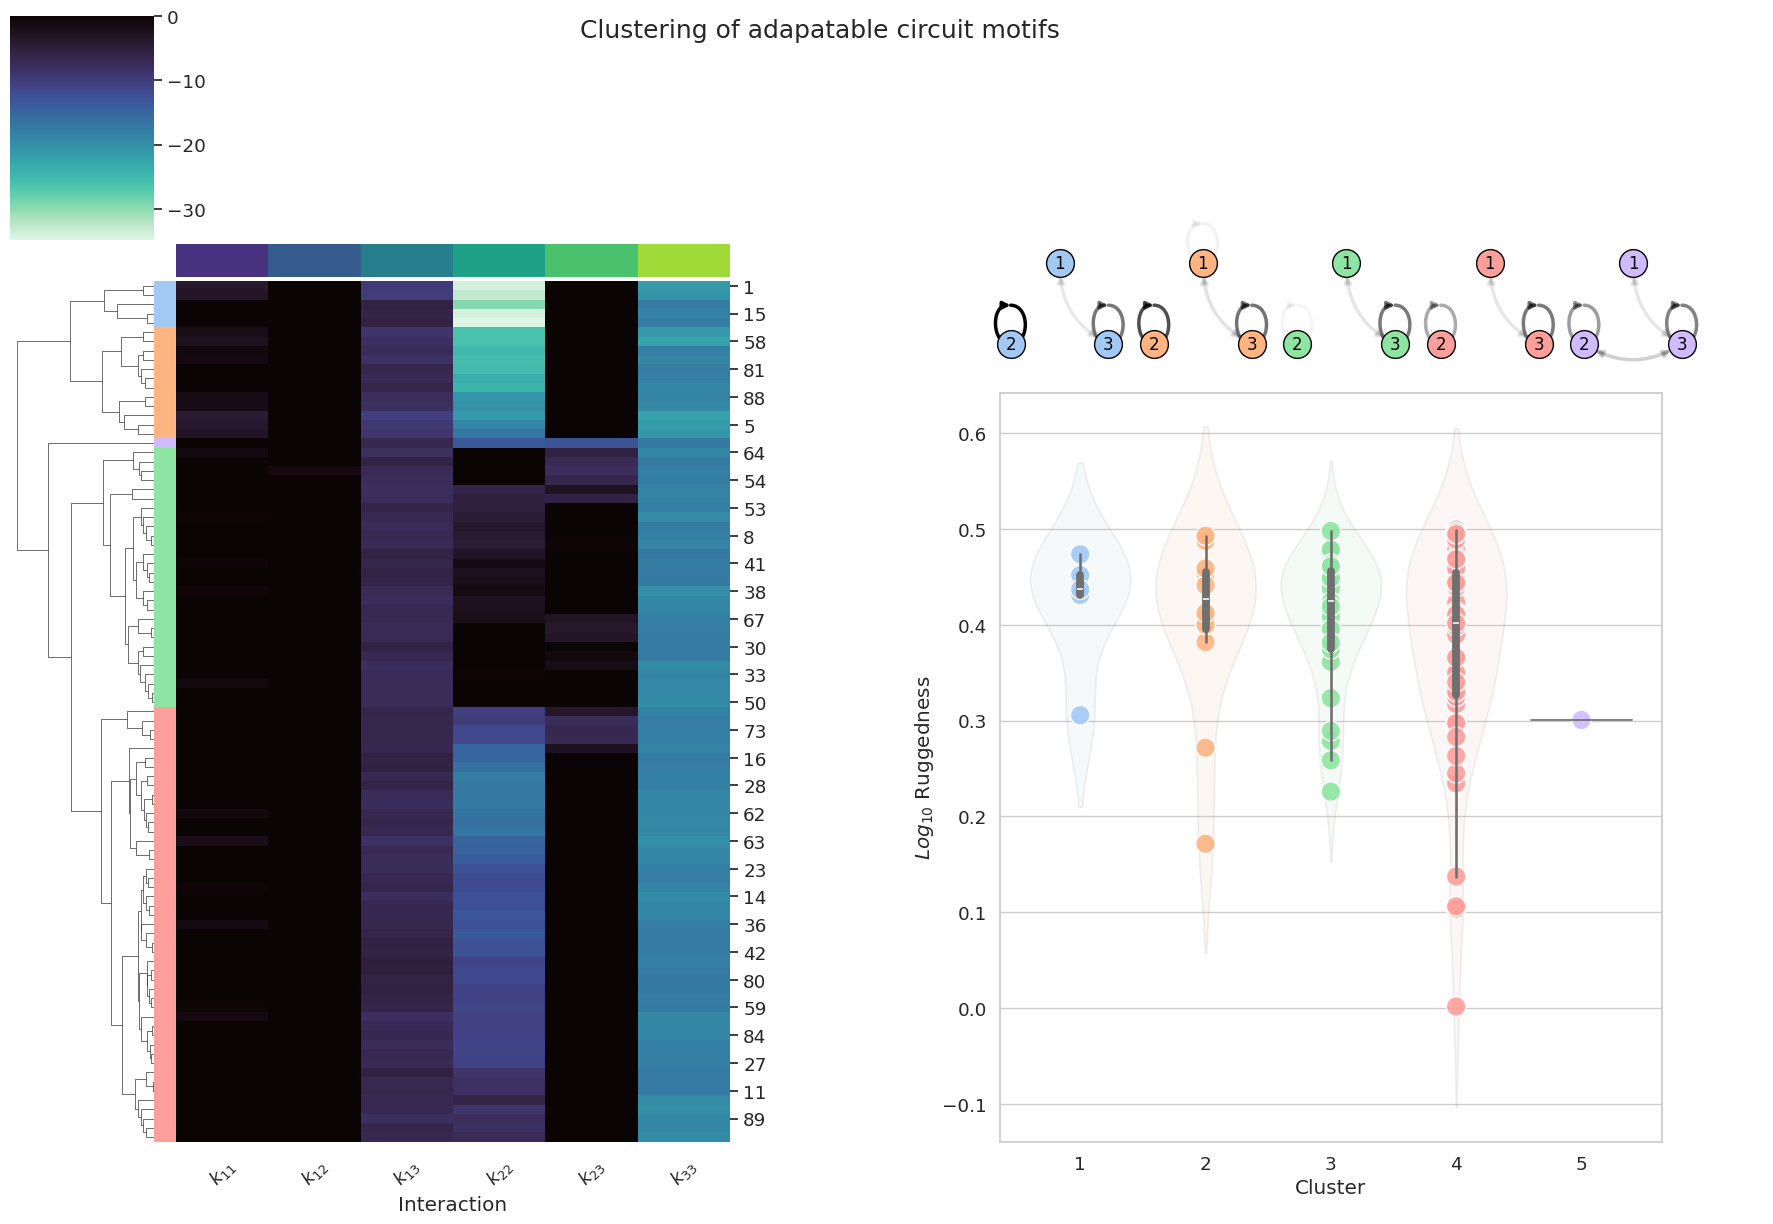

/tmp/ipykernel_9410/1234494209.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g2 = sns.violinplot(data=df_plot, x='Cluster',
/tmp/ipykernel_9410/1234494209.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


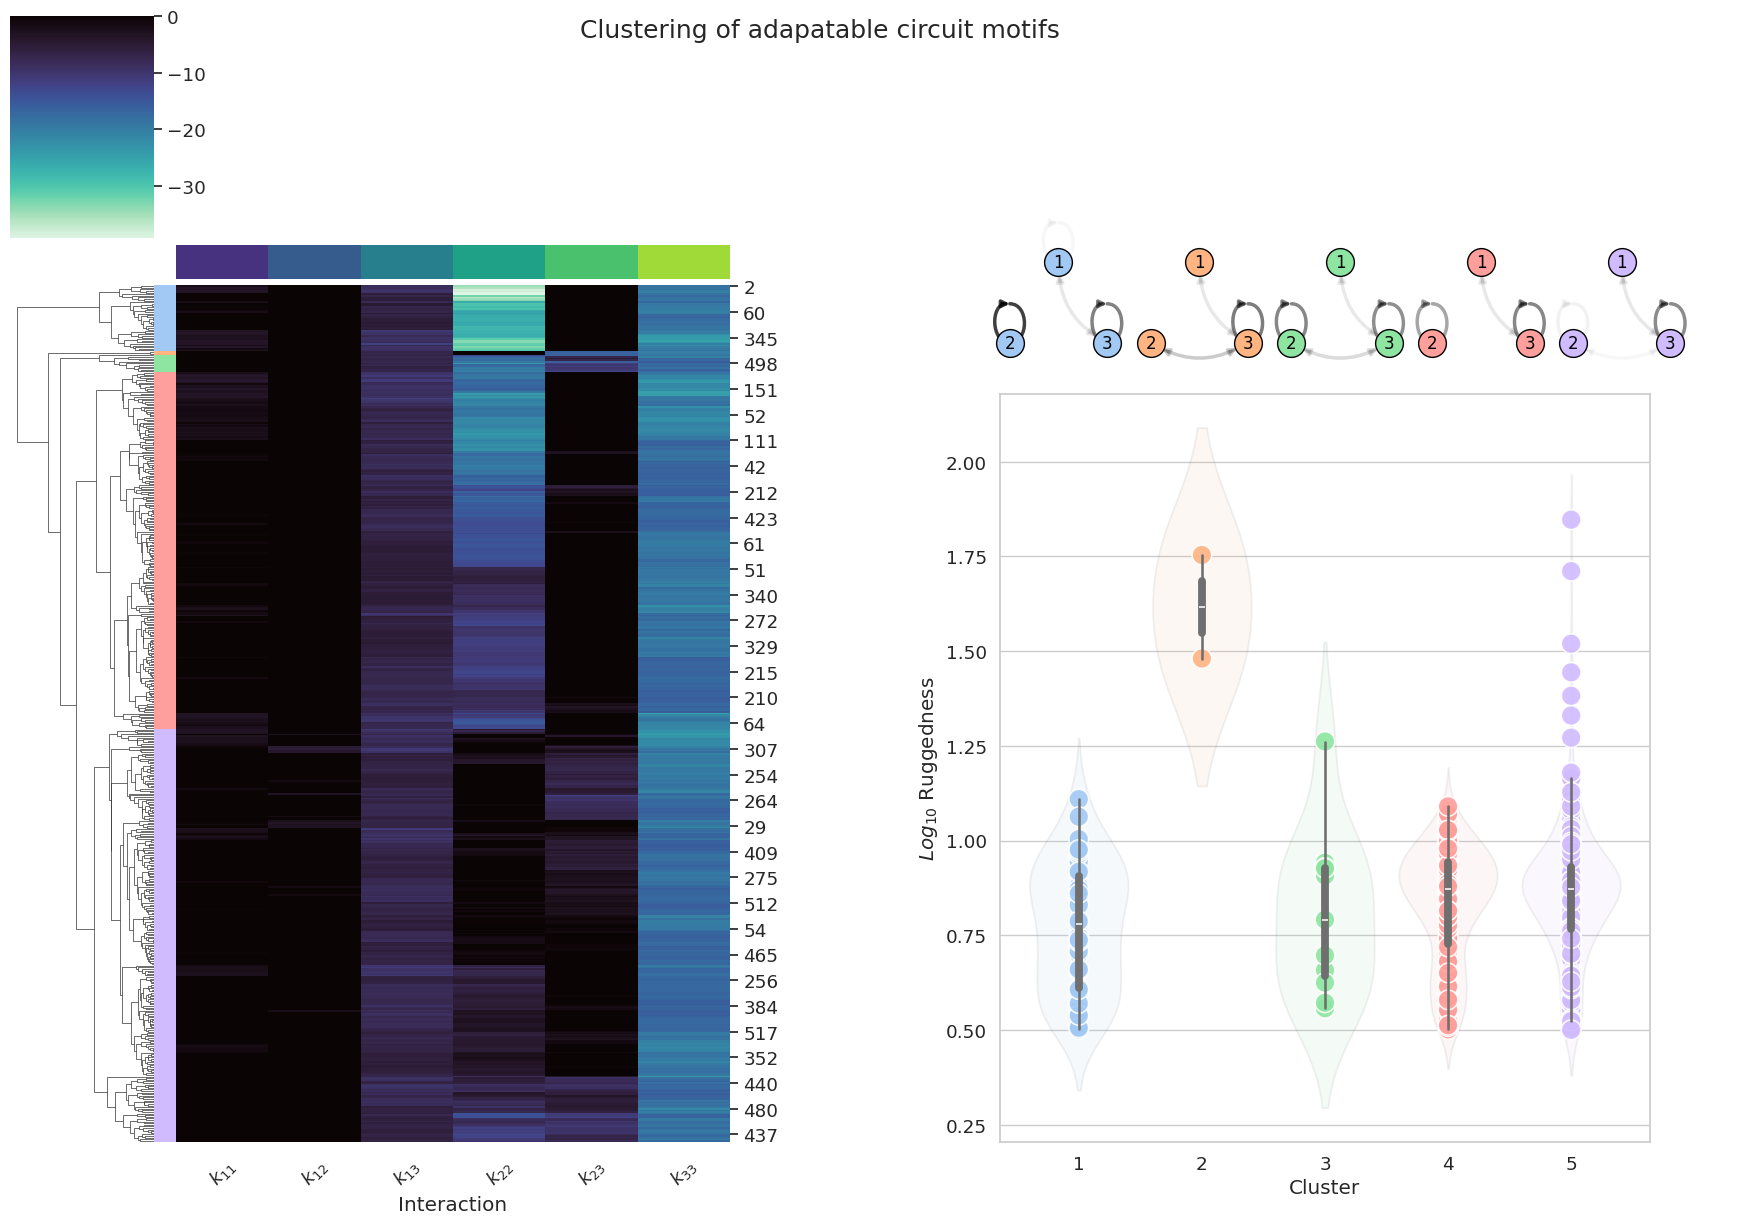

In [84]:
def plot_clusters(idxs, filt, save_name, n_clusters=5):
    g = sns.clustermap(all_fake_circuits_flat[idxs], col_cluster=False)
    row_linkage = g.dendrogram_row.linkage
    clusters = fcluster(row_linkage, t=n_clusters, criterion='maxclust')
    df_plot = pd.DataFrame()
    df_plot['Cluster'] = clusters
    df_plot[cols_e] = all_fake_circuits_flat[idxs]
    df_plot['Log ruggedness (adaptation)'] = df_rugg[filt]['Log ruggedness (adaptation)'].values
    lut = dict(zip(sorted(df_plot['Cluster'].unique()),
                   sns.color_palette('pastel', n_clusters).as_hex()))
    row_colors = df_plot['Cluster'].map(lut).to_numpy()
    col_colors = sns.color_palette(
        'viridis', all_fake_circuits_flat.shape[-1]).as_hex()

    plt.close()
    del g

    sns.set_style('whitegrid')

    figsize = (18, 12)
    g = sns.clustermap(all_fake_circuits_flat[idxs], col_cluster=False,
                       col_colors=sns.color_palette(
        "viridis", all_fake_circuits_flat.shape[-1]),
        row_colors=row_colors, figsize=figsize,
        cmap='mako_r')
    g.ax_heatmap.set_xlabel('Interaction')
    g.ax_heatmap.set_xticklabels(cols_e, rotation=45)
    g.gs.update(left=0.05, right=0.45)

    gs2 = matplotlib.gridspec.GridSpec(3, 1, left=0.6)
    ax2 = g.figure.add_subplot(gs2[0])
    ax3 = g.figure.add_subplot(gs2[1:])

    # g2 = sns.barplot(data=df_plot.melt(id_vars=['Cluster'],
    #                                    value_vars=cols_e,
    #                                    value_name='Energy (kcal/mol)',
    #                                    var_name='Interaction').sort_values('Interaction'),
    #                  x='Cluster', y='Energy (kcal/mol)', hue='Interaction',
    #                  ax=ax3, palette='viridis')
    # g2 = sns.boxplot(data=df_plot, x='Cluster', y='Log ruggedness (adaptation)', ax=ax3, palette='pastel')
    g2 = sns.violinplot(data=df_plot, x='Cluster',
                        y='Log ruggedness (adaptation)', ax=ax3, palette='pastel', alpha=0.1)
    df_plot['Cluster 0'] = df_plot['Cluster'] - 1
    g2 = sns.scatterplot(data=df_plot, x='Cluster 0', y='Log ruggedness (adaptation)', hue='Cluster', ax=ax3, palette='pastel',
                         s=200, alpha=0.9, legend=False)
    ax3.set_ylabel(r'$Log_{10}$ Ruggedness')
    # sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))

    # ax2.set_title('Interactions per cluster')
    ax2.set_axis_off()
    pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1) - 0.2) * 1.3,
                          np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
    colors = sns.color_palette('pastel', n_clusters).as_hex()
    for i, c in enumerate(sorted(df_plot['Cluster'].unique())):
        fake_circuits_cluster = df_plot[df_plot['Cluster']
                                        == c][cols_e].values
        w = np.median(fake_circuits_cluster, axis=0)
        create_network_inset(fig, ax2,
                             pos=pos[i],
                             width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                                 vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
                             node_color=colors[i], linewidth=2.5)

    plt.suptitle('Clustering of adapatable circuit motifs', fontsize=18)
    plt.tight_layout()
    plt.savefig(os.path.join(
        top_write_dir, save_name + '.png'), dpi=300, transparent=True)

    plt.show()

    return df_plot


n_clusters = 5
df_plot = plot_clusters(idxs_adaptable, filt_adaptable,
                        'interaction_energy_clusters', n_clusters)
df_plot_lo = plot_clusters(
    idxs_adaptable_lorugg2, filt_adaptable_lorugg, 'interaction_energy_clusters_lo', n_clusters=5)
df_plot_hi = plot_clusters(
    idxs_adaptable_hirugg2, filt_adaptable_hirugg, 'interaction_energy_clusters_hi', n_clusters=5)

/tmp/ipykernel_9410/493492883.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.violinplot(data=df_plot, x='Cluster', y='Log ruggedness (adaptation)',


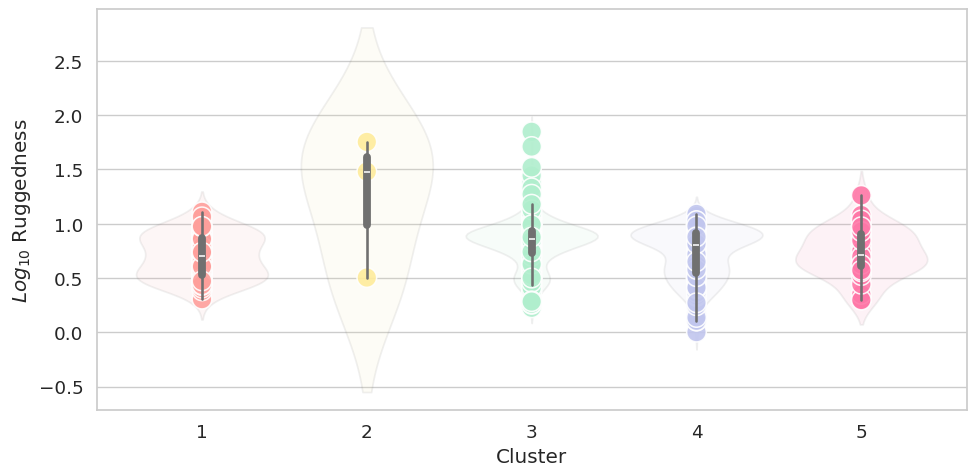

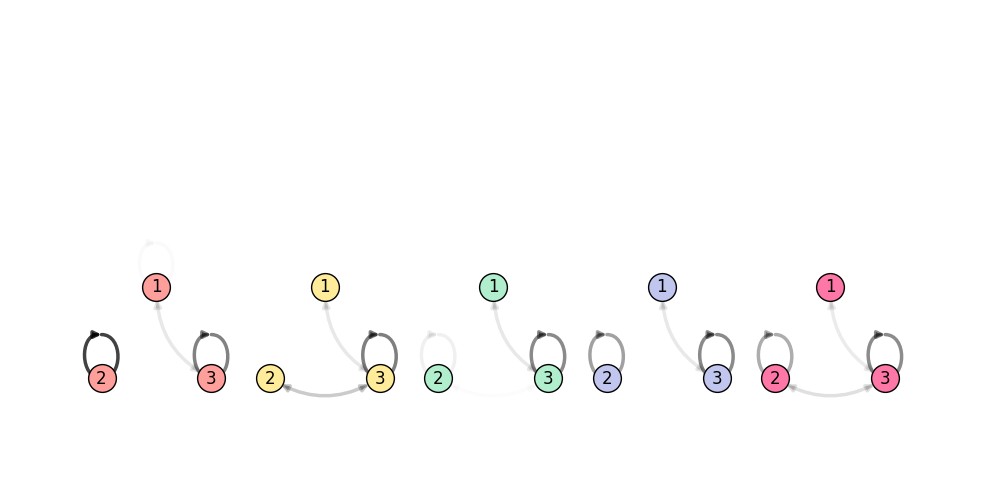

In [85]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

n_clusters = df_plot['Cluster'].nunique()
custom_palette = sns.blend_palette(['#ff9f9b', '#ffb482', '#fffea3', '#c1f6b8', '#a0e7e0', '#b9d3ee', '#d6a4ef', '#ff77a7'], n_colors=n_clusters)

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
ax = axs
g = sns.violinplot(data=df_plot, x='Cluster', y='Log ruggedness (adaptation)',
                   ax=ax, palette=custom_palette, alpha=0.1)
g = sns.scatterplot(data=df_plot, x='Cluster 0', y='Log ruggedness (adaptation)', hue='Cluster', ax=ax, palette=custom_palette,
                    s=200, alpha=0.9, legend=False)
ax.set_ylabel(r'$Log_{10}$ Ruggedness')
plt.tight_layout()
plt.savefig(os.path.join(
    top_write_dir, 'interaction_energy_clusters_horiz1.png'), dpi=300, transparent=True)

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
ax = axs
ax.set_axis_off()
pos = np.concatenate([(np.arange(n_clusters) / (n_clusters+1) - 0.2) * 1.2,
                      np.ones(n_clusters) * - 0.1]).reshape(2, -1).T
colors = sns.color_palette(custom_palette, n_clusters).as_hex()
for i, c in enumerate(sorted(df_plot['Cluster'].unique())):
    fake_circuits_cluster = df_plot[df_plot['Cluster']
                                    == c][cols_e].values
    w = np.median(fake_circuits_cluster, axis=0)
    create_network_inset(fig, ax, pos=pos[i],
                         width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                             vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
                         node_color=colors[i], linewidth=2.5)
plt.tight_layout()
plt.savefig(os.path.join(
    top_write_dir, 'interaction_energy_clusters_horiz2.png'), dpi=300, transparent=True)

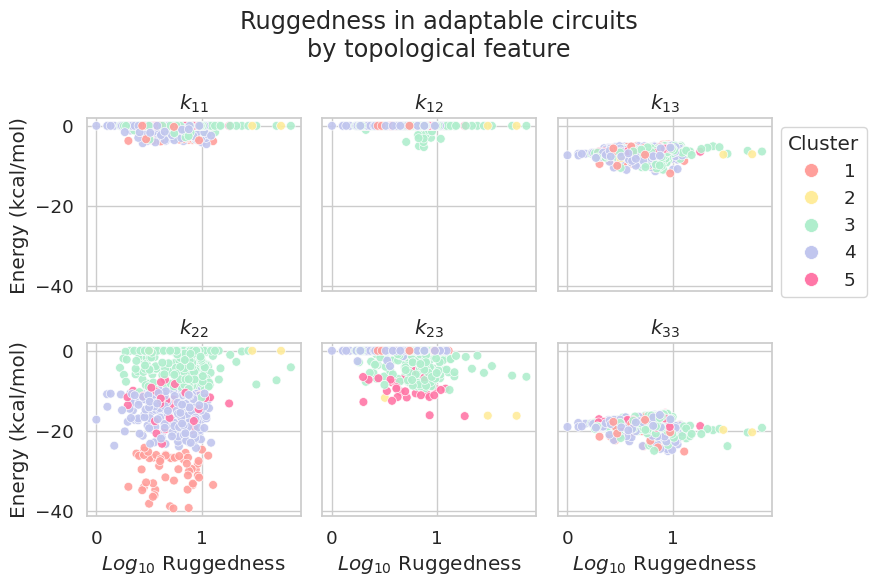

In [86]:
fig, axs = plt.subplots(2, 3, figsize=(3*3, 3*2), sharex=True, sharey=True)
# df_plot = df_plot.iloc[np.random.choice(np.arange(len(df_plot)), len(df_plot))]
for i, c in enumerate(cols_e):

    is_legend = True if i == 2 else False
    g = sns.scatterplot(df_plot,
                        x='Log ruggedness (adaptation)', y=c, hue='Cluster', alpha=0.9, s=40,
                        ax=axs.flat[i], palette=custom_palette, legend=is_legend)
    axs.flat[i].set_xlabel(r'$Log_{10}$ Ruggedness')
    axs.flat[i].set_ylabel('Energy (kcal/mol)')
    axs.flat[i].set_title(labels_x[i])
    

    if is_legend:
        for line in g.legend().get_lines():
            line.set(alpha=1.0, markersize=10)
        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title='Cluster')

plt.suptitle('Ruggedness in adaptable circuits\nby topological feature')
plt.tight_layout()
plt.savefig(os.path.join(
    top_write_dir, 'ruggedness_by_interaction_energy.png'), dpi=300, transparent=True)

/tmp/ipykernel_9410/3264670728.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


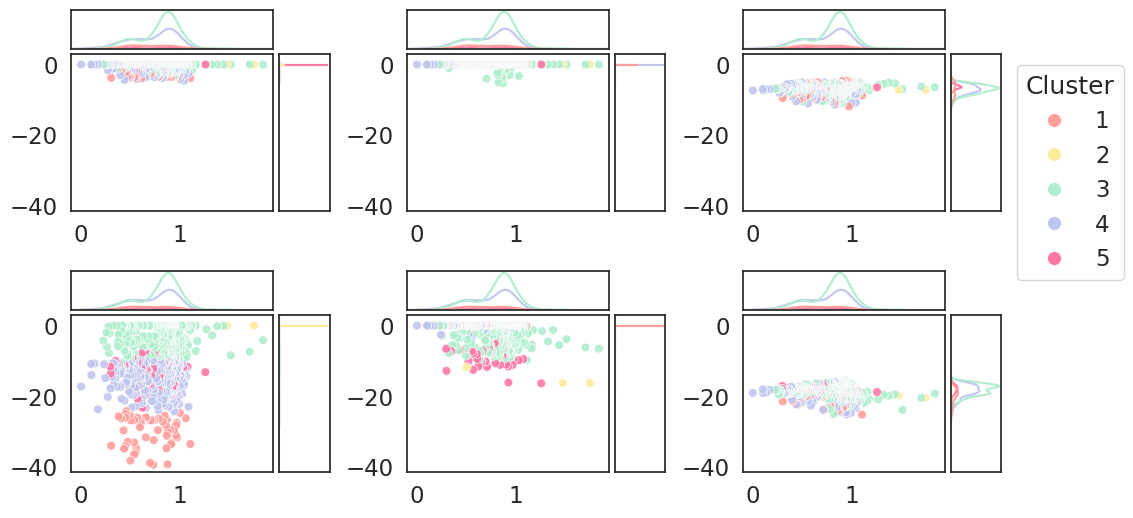

In [131]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 6))
outer = gridspec.GridSpec(2, 3, wspace=0.3, hspace=0.3)
x_label = 'Log ruggedness (adaptation)'
xlim = (df_plot[x_label].min() - 0.1, df_plot[x_label].max() + 0.1)
ylim = (df_plot[cols_e].min().min() - 2, df_plot[cols_e].max().max() + 3)

for i, c in enumerate(cols_e):
    is_legend = True if i == 2 else False

    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                                             subplot_spec=outer[i],
                                             width_ratios=[4, 1],
                                             height_ratios=[1, 4],
                                             wspace=0.05, hspace=0.05)

    # Histogram (top)
    ax_xhist = plt.Subplot(fig, inner[0, 0])
    sns.kdeplot(df_plot,
                x=x_label,
                hue='Cluster', palette=custom_palette,
                ax=ax_xhist, legend=False)
    ax_xhist.set_xlim(xlim)
    ax_xhist.set_xticks([])
    ax_xhist.set_yticks([])
    ax_xhist.set_xlabel('')
    ax_xhist.set_ylabel('')
    # ax_xhist.set_title(labels_x[i])
    fig.add_subplot(ax_xhist)

    # Right y-histogram
    ax_yhist = plt.Subplot(fig, inner[1, 1])
    sns.kdeplot(df_plot,
                y=c,
                hue='Cluster', palette=custom_palette,
                ax=ax_yhist, legend=False)
    ax_yhist.set_ylim(ylim)
    ax_yhist.set_xticks([])
    ax_yhist.set_yticks([])
    ax_yhist.set_xlabel('')
    ax_yhist.set_ylabel('')
    fig.add_subplot(ax_yhist)

    # Scatterplot (bottom)
    ax_scatter = plt.Subplot(fig, inner[1, 0])
    g = sns.scatterplot(df_plot,
                        x=x_label, y=c, hue='Cluster', alpha=0.9, s=40,
                        ax=ax_scatter, palette=custom_palette, legend=is_legend)
    ax_scatter.set_xlim(xlim)
    ax_scatter.set_ylim(ylim)
    ax_scatter.set_xlabel('')
    ax_scatter.set_ylabel('')
    # ax_scatter.set_xlabel(r'$Log_{10}$ Ruggedness')
    # ax_scatter.set_ylabel('Energy (kcal/mol)')
    if is_legend:
        for line in g.legend().get_lines():
            line.set(alpha=1.0, markersize=10)
        sns.move_legend(g, "upper left", bbox_to_anchor=(1.3, 1), title='Cluster')

    fig.add_subplot(ax_scatter)


# plt.suptitle('Ruggedness in adaptable circuits\nby topological feature')
plt.tight_layout()
plt.savefig(os.path.join(
    top_write_dir, 'ruggedness_by_interaction_energy2.png'), dpi=300, transparent=True)

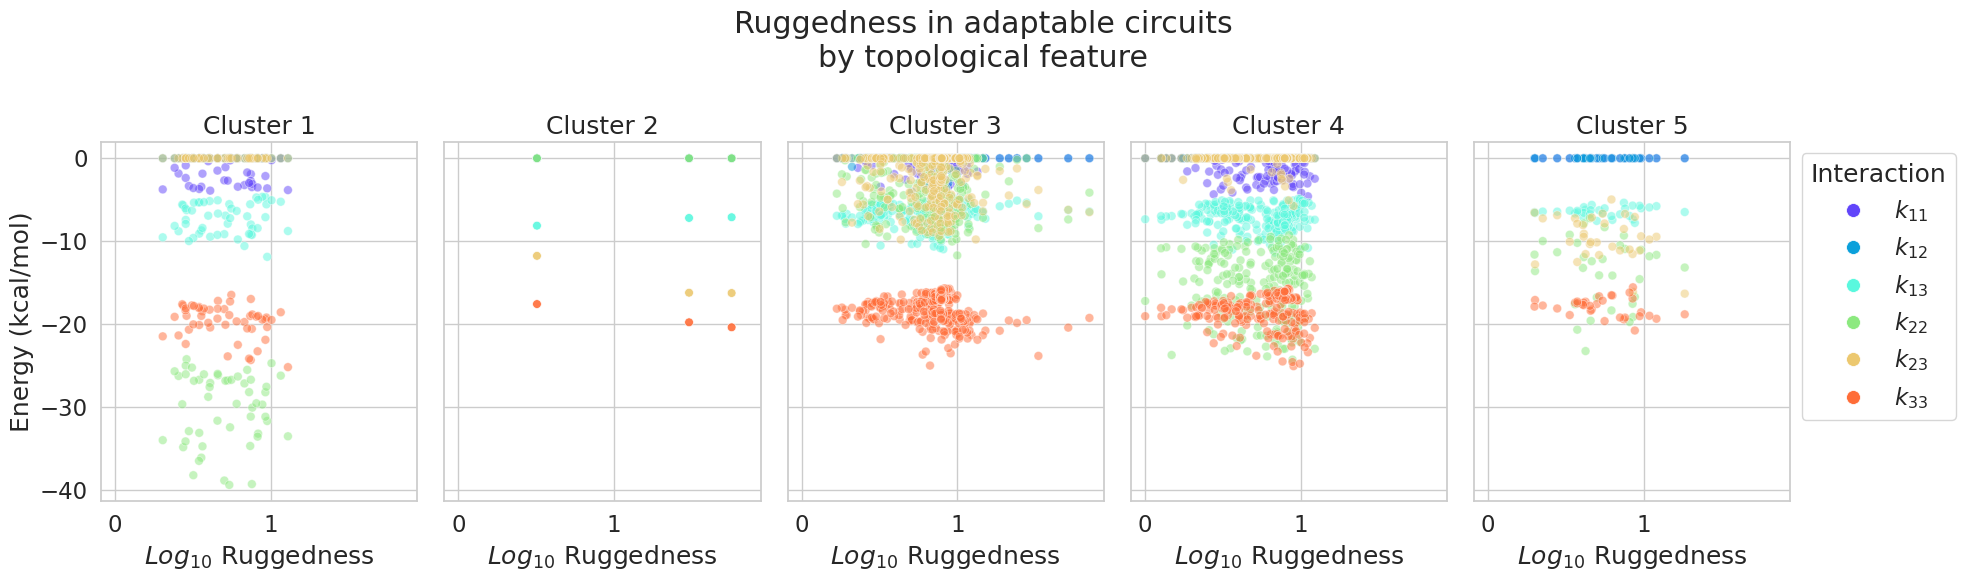

In [166]:
sns.set_style('whitegrid')
nrows = 1
ncols = df_plot['Cluster'].nunique()
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows), sharex=True, sharey=True)

dfm = df_plot.melt(id_vars=['Cluster', 'Log ruggedness (adaptation)'],
                   value_vars=cols_e, value_name='Energy (kcal/mol)', var_name='Interaction name').sort_values('Interaction name')
dfm['Interaction'] = dfm['Interaction name'].apply(
    lambda x: dict(zip(cols_e, np.arange(len(cols_e))))[x])

# custom_palette2 = 'hls' # sns.blend_palette(['#ff9f9b', '#ffb482', '#fffea3', '#c1f6b8', '#a0e7e0', '#b9d3ee', '#d6a4ef', '#ff77a7'], n_colors=len(cols_e))
custom_palette2 = sns.blend_palette(["#6145fa", "#0ba0db", "#5af8de", "#8ce97f", '#ecc86f', '#ff6d38'], n_colors=len(cols_e))

for ic, cluster in enumerate(sorted(df_plot['Cluster'].unique())):

    d = dfm[dfm['Cluster'] == cluster]
    is_legend = True if ic == (ncols - 1) else False
    g = sns.scatterplot(d,
                        x='Log ruggedness (adaptation)', y='Energy (kcal/mol)', hue='Interaction name', 
                        alpha=0.5 if len(d) > 20 else 0.9, s=40,
                        ax=axs.flat[ic], palette=custom_palette2, legend=is_legend)
    axs.flat[ic].set_xlabel(r'$Log_{10}$ Ruggedness')
    axs.flat[ic].set_ylabel('Energy (kcal/mol)')
    axs.flat[ic].set_title(f'Cluster {cluster}')

    if is_legend:
        for line in g.legend().get_lines():
            line.set(alpha=1.0, markersize=10)
        sns.move_legend(g, "upper left", bbox_to_anchor=(
            1, 1), title='Interaction')

plt.suptitle('Ruggedness in adaptable circuits\nby topological feature')
plt.tight_layout()
plt.savefig(os.path.join(
    top_write_dir, 'ruggedness_by_interaction_cluster.png'), dpi=300, transparent=True)

# Crazy circle motif graphs

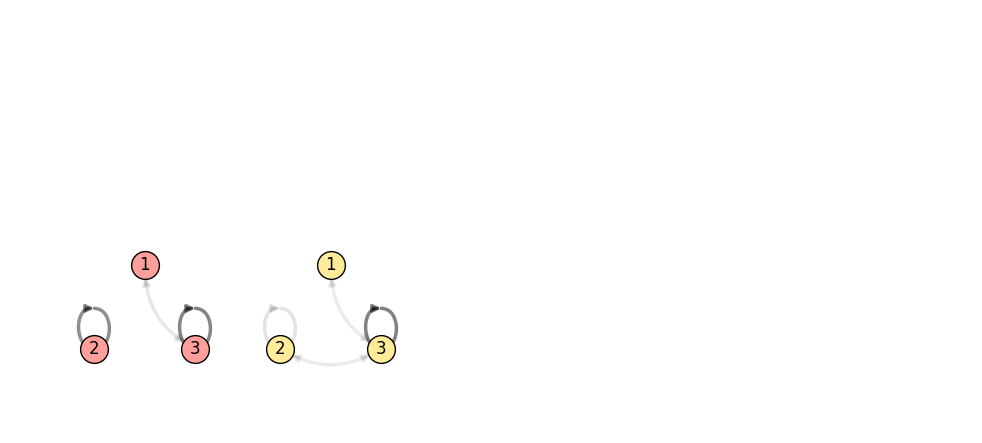

In [88]:
fig, ax = plt.subplots(figsize=(12, 5))
i_rlowest = df_plot['Log ruggedness (adaptation)'].idxmin()
i_rhighest = df_plot['Log ruggedness (adaptation)'].idxmax()
for i, idx in enumerate([i_rlowest, i_rhighest]):
    w = df_plot.iloc[idx][cols_e].values
    # w = np.median(fake_circuits_cluster, axis=0)
    create_network_inset(fig, ax,
                         pos=pos[i],
                         width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3,
                                                                             vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
                         node_color=colors[i], linewidth=2.5)
ax.set_axis_off()

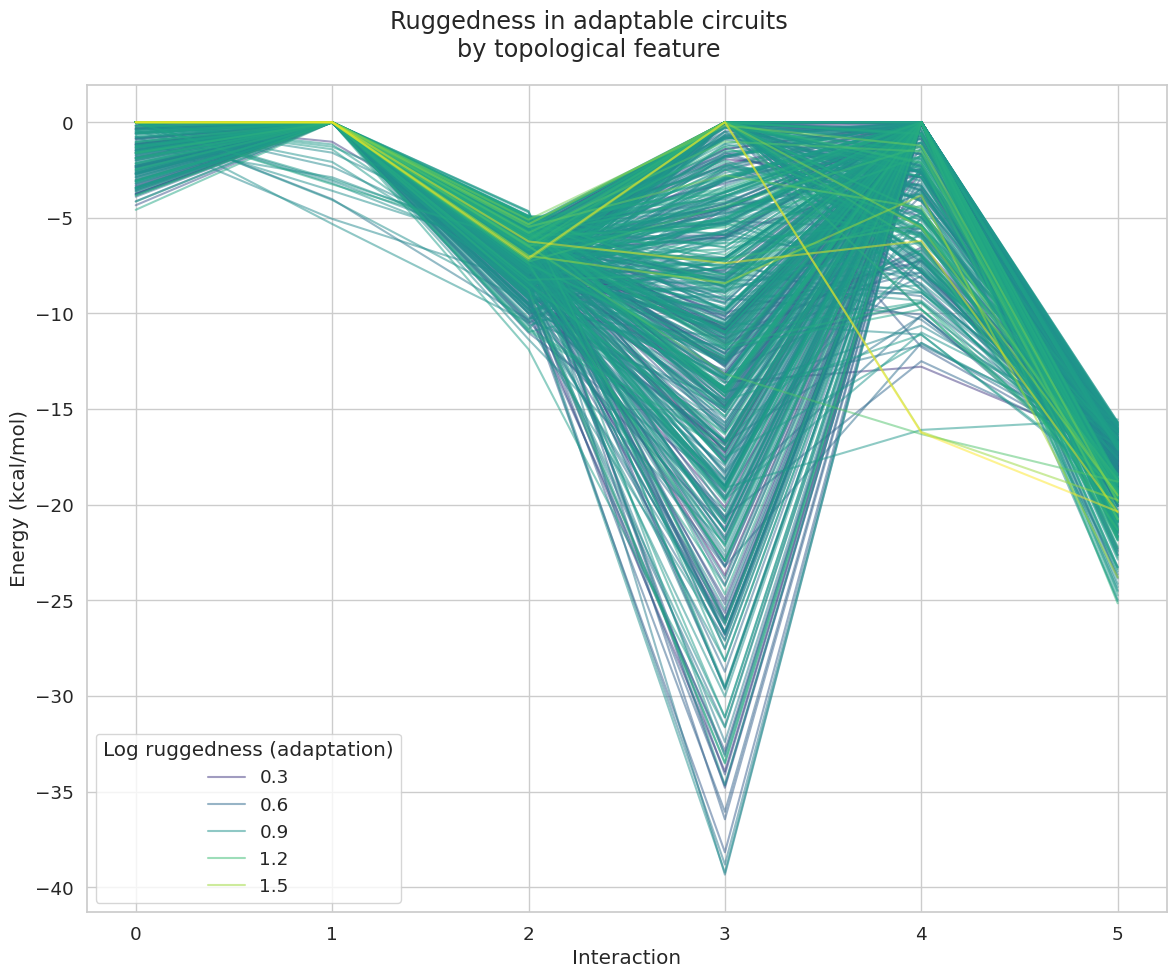

In [89]:
dfm = df_plot.melt(id_vars=['Cluster', 'Log ruggedness (adaptation)'],
                   value_vars=cols_e, value_name='Energy (kcal/mol)', var_name='Interaction name').sort_values('Interaction name')
dfm['Interaction'] = dfm['Interaction name'].apply(
    lambda x: dict(zip(cols_e, np.arange(len(cols_e))))[x])

plt.figure(figsize=(12, 10))
sns.lineplot(dfm[dfm['Log ruggedness (adaptation)'] < 1.8].sort_values(by='Energy (kcal/mol)', ascending=True),
             x='Interaction', y='Energy (kcal/mol)',
             hue='Log ruggedness (adaptation)', alpha=0.5,
             palette='viridis') 
# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

plt.suptitle('Ruggedness in adaptable circuits\nby topological feature')
plt.tight_layout()
# plt.savefig(os.path.join(
#     top_write_dir, 'ruggedness_by_interaction_energy.png'), dpi=300, transparent=True)

### Radar chart

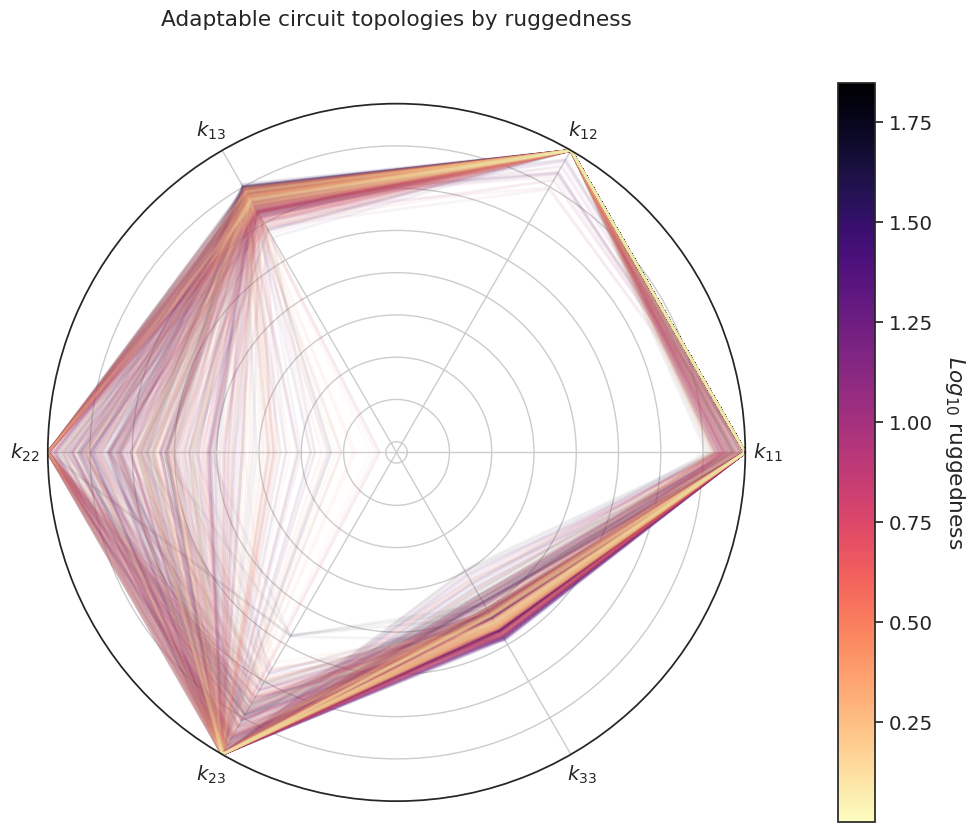

In [119]:
def plot_radar_chart(df, i, ax, cols, labels, color='tab:blue', linewidth=2, alpha=0.05):
    # Step 1: Prepare data
    categories = labels
    values = (df[cols].iloc[i].round(1)).tolist()
    values += values[:1]  # repeat first value to close the circle

    # Step 2: Calculate angles for each axis
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    # Step 3: Create radar chart
    ax.plot(angles, values, color=color, linewidth=linewidth, alpha=alpha)
    # ax.fill(angles, values, color='tab:blue', alpha=0.25) 

    # Step 4: Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticklabels([])  # hide radial ticks for cleaner look

    # Optional: Set range for radial axis
    # ax.set_ylim(0, 5)
    

df_plot = df_plot.sort_values(by='Log ruggedness (adaptation)', ascending=False)
colors = sns.color_palette("magma_r", n_colors=len(df_plot) ).as_hex()
colors = np.array(colors)[np.argsort(df_plot['Log ruggedness (adaptation)'].values)]
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
# df_plot[cols_e_norm] = df_plot[cols_e] / df_plot[cols_e].abs().max(axis=0)
for i in range(len(df_plot)):
    plot_radar_chart(df_plot, i, ax, cols_e, labels=cols_e, color=colors[i])

plt.title("Adaptable circuit topologies by ruggedness", y=1.1)
 
norm = plt.Normalize(vmin=df_plot['Log ruggedness (adaptation)'].min().min(), vmax=df_plot['Log ruggedness (adaptation)'].max().max())
sm = plt.cm.ScalarMappable(cmap='magma_r', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label(f'$Log_{{10}}$ ruggedness', rotation=270, labelpad=25)


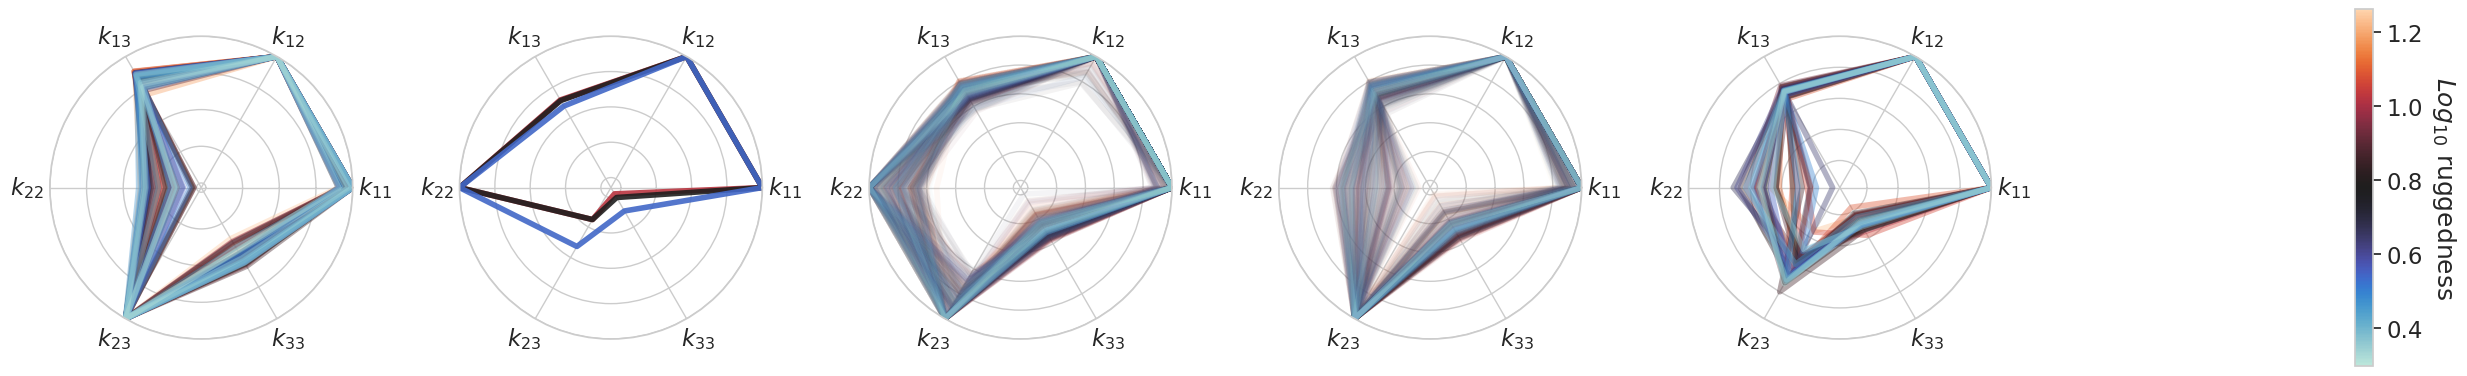

In [141]:
sns.set_context("notebook", font_scale=1.5)

palette = 'icefire' #'magma_r'
# cividis, crest, cubehelix_r, gist_earth, icefire, jet, managua, nipy_spectral, rainbow, prism, seismic
fig, axs = plt.subplots(1, 6, figsize=(5*5, 5), subplot_kw=dict(polar=True))
plt.subplots_adjust(wspace=0.1)
for ic, cluster in enumerate(sorted(df_plot['Cluster'].unique())):
    
    d = df_plot[df_plot['Cluster'] == cluster]
    colors = sns.color_palette(palette, n_colors=len(d)).as_hex()
    colors = np.array(colors)[np.argsort(d['Log ruggedness (adaptation)'].values)]
    
    alpha = 0.05 if len(d) > 100 else (0.4 if len(d) > 20 else 0.9)
    for i in range(len(d)):
        plot_radar_chart(d, i, axs[ic], cols_e, labels=cols_e, color=colors[i], linewidth=4, alpha=alpha)

norm = plt.Normalize(vmin=d['Log ruggedness (adaptation)'].min().min(), vmax=d['Log ruggedness (adaptation)'].max().max())
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs[-1], orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label(f'$Log_{{10}}$ ruggedness', rotation=270, labelpad=25)
axs[-1].set_axis_off()

plt.tight_layout()


# Timeseries subplots of high vs. low ruggedness circuits

In [91]:
fn_ys = os.path.join(dir_src_rugg, 'ys.npy')

if os.path.exists(fn_ys):
    ys = np.load(fn_ys)
    ts = np.load(os.path.join(dir_src_rugg, 'ts.npy'))
else:
    # Stitch together ys from batches
    ys = np.array([])
    ts = np.array([])
    idxs_adaptable = np.array(idxs_adaptable)

    n_batches = len([i for i in os.listdir(dir_src_rugg) if 'batch' in i])
    batch_sizes = []
    for i in np.arange(n_batches):
        dir_batch = f'batch_{i}'
        if (not os.path.exists(os.path.join(dir_src_rugg, dir_batch))) or (
            len(os.listdir(os.path.join(dir_src_rugg, dir_batch))) == 0):
            continue
        ys_batch = np.load(os.path.join(dir_src_rugg, dir_batch, 'ys.npy'))
        ts = np.load(os.path.join(dir_src_rugg, dir_batch, 'ts.npy'))
        
        batch_size = len(ys_batch) // n_perturbs
        idxs = idxs_adaptable[(idxs_adaptable >= int(np.sum(batch_sizes))) & (idxs_adaptable < int(np.sum(batch_sizes)) + batch_size)]
        idxs = idxs - int(np.sum(batch_sizes))
        ys_batch = ys_batch.reshape(-1, n_perturbs, ys_batch.shape[-2], ys_batch.shape[-1])
        ys_batch = ys_batch[idxs]
        if not len(ys):
            ys = np.array(ys_batch)
        else:
            ys = np.concatenate([ys, ys_batch], axis=0)
        batch_sizes.append(batch_size)

            

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

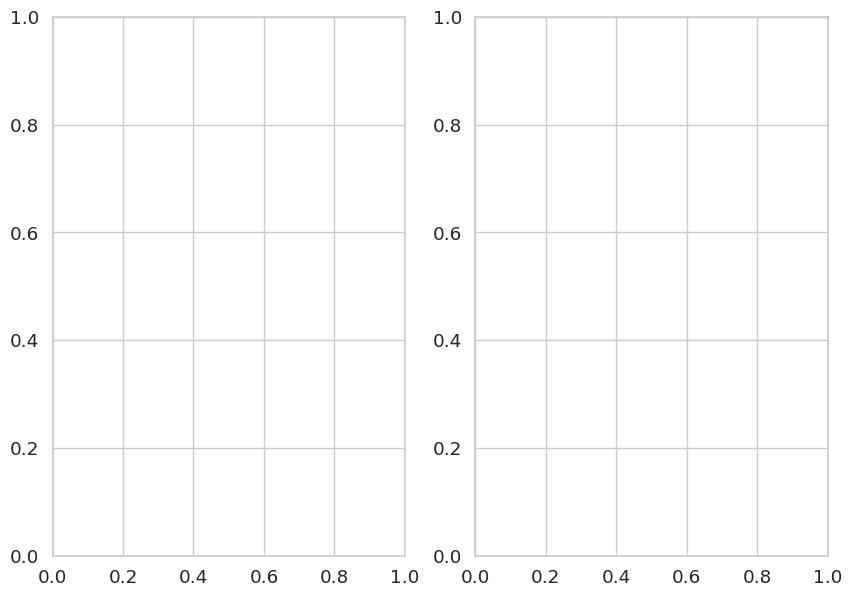

In [92]:
n_show_circs = 7
idxs_full_adapt_lorugg = df_plot.sort_values(by='Log ruggedness (adaptation)', ascending=True).index.to_list()[:n_show_circs]
idxs_full_adapt_hirugg = df_plot.sort_values(by='Log ruggedness (adaptation)', ascending=False).index.to_list()[:n_show_circs]

# Create a figure with two large subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

sns.set_style('white')

nrows = n_show_circs
ncols = n_perturbs
for i, (ax, idxs, title) in enumerate(zip(axs, [idxs_full_adapt_lorugg, idxs_full_adapt_hirugg], ['Low ruggedness', 'High ruggedness'])):
    # Create a 5x5 grid of subplots within each large subplot
    # for ii, (row, col) in enumerate(itertools.product(range(n_show_circs), range(n_perturbs))):
    itmax = len(ts) // 2
    for row in range(nrows):
        ymin = np.nanmin(ys[idxs[row], :, :, idxs_output])
        ymax = np.nanmax(ys[idxs[row], :, :, idxs_output])
        for col in range(ncols):
            inset_ax = ax.inset_axes([col * 1/ncols, 1 - (row + 1) * 1/nrows, 1/ncols, 1/nrows])
            inset_ax.plot(ts[:itmax], ys[idxs[row], col, :itmax, idxs_output] + row + col, color=sns.color_palette('husl', nrows)[row])
            inset_ax.set_xticks([])
            inset_ax.set_yticks([])
            ylim = (ymin - 0.02*ymin + row + col, ymax + 0.02*ymax + row + col)
            inset_ax.set_ylim(ylim)
            for spine in inset_ax.spines.values():
                spine.set_edgecolor('lightgrey')

    tick_labels = [''] * 5 + ['Original']
    for c in cols_e:
        tick_labels = tick_labels + [''] * 10 + [f'$\Delta$' + c]
    tick_labels = tick_labels + [''] * 5
    ax.set_xticks(np.arange(len(tick_labels)))
    ax.set_xticklabels(tick_labels, fontsize=12)
    ax.set_yticks([])
    if i == 0:
        ax.set_yticks(np.arange(nrows+1))
        ax.set_yticklabels((list(np.arange(nrows) + 1) + [''])[::-1], fontsize=12)
        ax.set_ylabel('Circuit index')
    ax.set_title(title, fontsize=16)
    
# Adjust layout and show the figure
plt.suptitle('Adaptable circuits with low and high ruggedness', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'timeseries_stack.png'), dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
df_rugg['overshoot/initial'] = df_rugg['overshoot'] / df_rugg['initial_steady_states']

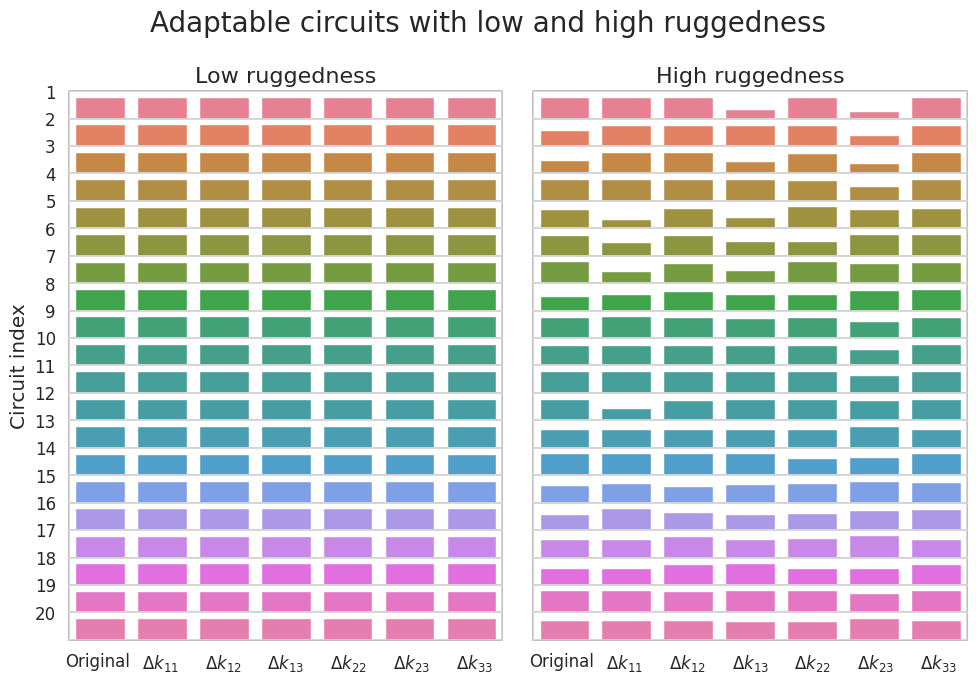

In [ ]:
n_show_circs = 20
idxs_lorugg = df_rugg[df_rugg['Adaptation'] > 850].sort_values(by='Log ruggedness (adaptation)', ascending=True).index.to_list()[:n_show_circs]
idxs_hirugg = df_rugg[df_rugg['Adaptation'] > 850].sort_values(by='Log ruggedness (adaptation)', ascending=False).index.to_list()[:n_show_circs]

fig, axs = plt.subplots(1, 2, figsize=(10, 7))
nrows = n_show_circs
ncols = n_perturbs
for i, (ax, idxs, title) in enumerate(zip(axs, [idxs_lorugg, idxs_hirugg], ['Low ruggedness', 'High ruggedness'])):

        
    for row in range(nrows):
        a = analytics_rugg['adaptation'].reshape(-1, n_perturbs, analytics_rugg['adaptation'].shape[-1])[idxs[row], :, idxs_output]
        # sns.lineplot(a, color=sns.color_palette('husl', n_show_circs)[row], ax=ax)
        # sns.scatterplot(a, color=sns.color_palette('husl', n_show_circs)[row], ax=ax)
        
        inset_ax = ax.inset_axes([0, 1 - (row + 1) * 1/nrows, 1, 1/nrows])
        sns.barplot(a, color=sns.color_palette('husl', n_show_circs)[row], ax=inset_ax)
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        for spine in inset_ax.spines.values():
            spine.set_edgecolor('lightgrey')
            
        inset_ax.set_ylim(700, inset_ax.get_ylim()[1])
        
    tick_labels = [''] * 5 + ['Original']
    for c in cols_e:
        tick_labels = tick_labels + [''] * 10 + [f'$\Delta$' + c]
    tick_labels = tick_labels + [''] * 5
    ax.set_xticks(np.arange(len(tick_labels)))
    ax.set_xticklabels(tick_labels, fontsize=12)
    ax.set_yticks([])
    if i == 0:
        ax.set_yticks(np.arange(nrows+1))
        ax.set_yticklabels((list(np.arange(nrows) + 1) + [''])[::-1], fontsize=12)
        ax.set_ylabel('Circuit index')
    ax.set_title(title, fontsize=16)

# Adjust layout and show the figure
plt.suptitle('Adaptable circuits with low and high ruggedness', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'timeseries_stack_bars.png'), dpi=300, bbox_inches='tight', transparent=True)